# Heart Disease Dataset
Dieser Datensatz stammt aus dem Jahr 1988 und besteht aus vier Teilmengen:
Cleveland, Ungarn, Schweiz und Long Beach V.
Er enthält 76 Merkmale, darunter auch das Zielmerkmal („target“), diese Version des Datensatzs enthält nur 12 Merkmale.


# Import & Datensatz

In [112]:
from sklearn.inspection import permutation_importance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap
import numpy as np

In [113]:
df = pd.read_csv("heart3.csv")
df_orginal = df.copy()

In [114]:
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

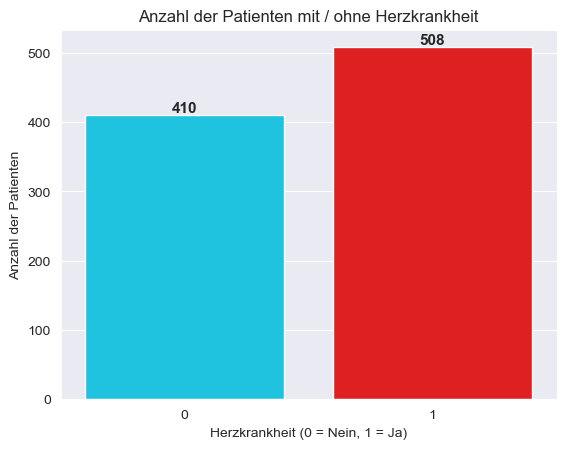

Anzahl der Zeilen (Patienten): 918
Anzahl der Spalten (Features): 12


In [115]:
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

# Daten Voberarbeitung

## Duplikate & Fehlende Werte

In [116]:
duplikate_df = df[df.duplicated(keep=False)]
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100


verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("kein Duplikate")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 918
Anzahl mehrfach vorkommender Zeilen: 0
Prozent mehrfach vorkommend: 0.00%

Verteilung von Heartdisease innerhalb der Duplikate:
kein Duplikate

Gesamtverteilung HeartDisease:
  1: 55.34%
  0: 44.66%


In [117]:
print("Fehlende Werte:")
print(df.isnull().sum())

Fehlende Werte:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


## Typprüfung
ob Datenentypen zu den bezeichnungen stimmen

In [118]:
def check_values(column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'M', 'F'},
    "ChestPainType": {'TA', 'ATA', 'NAP', 'ASY'},
    "RestingECG": {'Normal', 'ST', 'LVH'},
    "ExerciseAngina": {'Y', 'N'},
    "ST_Slope": {'Up', 'Flat', 'Down'}
}
def check_if_numeric (column_type):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'FastingBS',
    'MaxHR',
    'Oldpeak',
    'HeartDisease'
]

for column, valid_set in valid_values_dict.items():
    check_values(column, valid_set)

for col in numeric_columns:
    check_if_numeric(col)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'ChestPainType' sind gültig 
Alle Werte in Spalte 'RestingECG' sind gültig 
Alle Werte in Spalte 'ExerciseAngina' sind gültig 
Alle Werte in Spalte 'ST_Slope' sind gültig 
Alle Werte in Spalte 'Age' sind numerisch.
Alle Werte in Spalte 'RestingBP' sind numerisch.
Alle Werte in Spalte 'Cholesterol' sind numerisch.
Alle Werte in Spalte 'FastingBS' sind numerisch.
Alle Werte in Spalte 'MaxHR' sind numerisch.
Alle Werte in Spalte 'Oldpeak' sind numerisch.
Alle Werte in Spalte 'HeartDisease' sind numerisch.


## Unrealistische Werte

In [119]:
limits = {
    'Age': (0, 120),
    'RestingBP': (40, 150),
    'Cholesterol': (1, 800),
    'MaxHR': (60, 202),
    'Oldpeak': (0, 5)
}

print(f"Anzahl an Zeilen (vorher): {len(df)}")

def show_outliers(limits_dict):
    for col, (min_val, max_val) in limits_dict.items():
        invalid = df[(df[col] < min_val) | (df[col] > max_val)][col]
        print(f"{col}: {len(invalid)} Werte außerhalb ({min_val}–{max_val})")
        if not invalid.empty:
            print(f"    Beispiele: {invalid.unique()[:5]}")

def clip_outliers(limits_dict):
    df_clipped = df.copy()
    for col, (min_val, max_val) in limits_dict.items():
        before = df_clipped[col]
        df_clipped[col] = before.clip(lower=min_val, upper=max_val)
    print("\nClipping angewenden:")
    show_outliers(limits)
    return df_clipped

show_outliers(limits)
df = clip_outliers(limits)
print(f"\nNeue Anzahl an Zeilen (nach Filter): {len(df)}")

Anzahl an Zeilen (vorher): 918
Age: 0 Werte außerhalb (0–120)
RestingBP: 118 Werte außerhalb (40–150)
    Beispiele: [160 170 190 180 155]
Cholesterol: 172 Werte außerhalb (1–800)
    Beispiele: [0]
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 15 Werte außerhalb (0–5)
    Beispiele: [-0.9 -2.6 -1.5 -0.1 -1. ]

Clipping angewenden:
Age: 0 Werte außerhalb (0–120)
RestingBP: 118 Werte außerhalb (40–150)
    Beispiele: [160 170 190 180 155]
Cholesterol: 172 Werte außerhalb (1–800)
    Beispiele: [0]
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 15 Werte außerhalb (0–5)
    Beispiele: [-0.9 -2.6 -1.5 -0.1 -1. ]

Neue Anzahl an Zeilen (nach Filter): 918


## Bias/Korrelation

Altersverteilung 
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


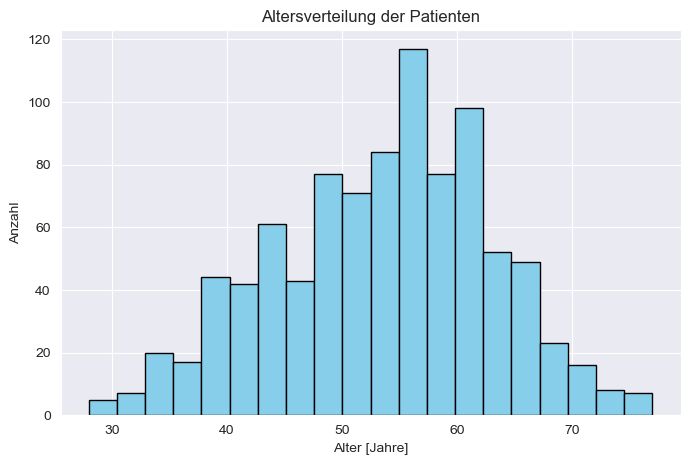

In [120]:
print("Altersverteilung ")
print(df['Age'].describe())

plt.figure(figsize=(8,5))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter [Jahre]')
plt.ylabel('Anzahl')
plt.show()

 Geschlechterverteilung 
M: 725 Patienten (78.98%)
F: 193 Patienten (21.02%)


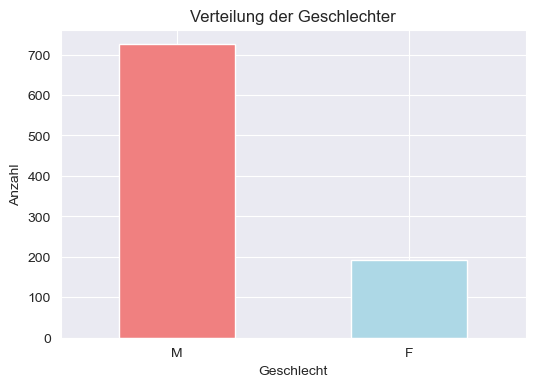

In [121]:
print(" Geschlechterverteilung ")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


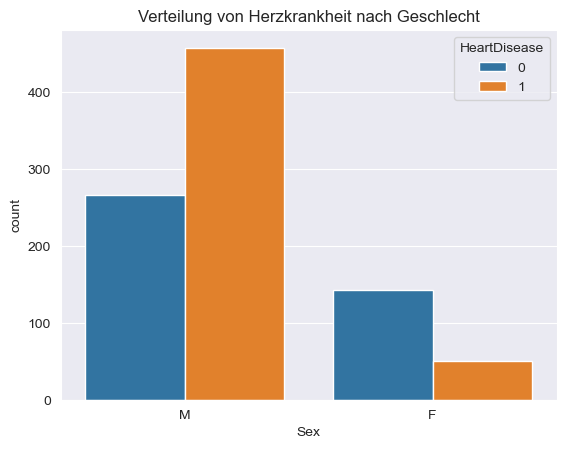

Sex
F    0.259067
M    0.631724
Name: HeartDisease, dtype: float64


In [122]:
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

print(df.groupby("Sex")["HeartDisease"].mean())

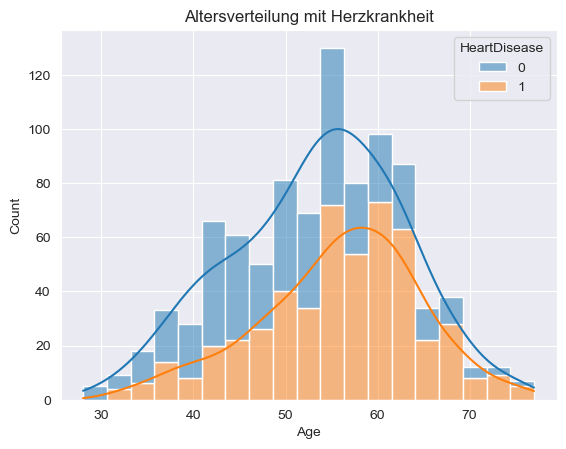

Age_cat
20–30    0.000000
31–40    0.363636
41–50    0.417040
51–60    0.582677
61–80    0.728507
Name: HeartDisease, dtype: float64


In [123]:
sns.histplot(data=df, x='Age', hue='HeartDisease', kde=True, multiple='stack')
plt.title("Altersverteilung mit Herzkrankheit")
plt.show()

df['Age_cat'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 80],
                        labels=["20–30", "31–40", "41–50", "51–60", "61–80"])
print(df.groupby("Age_cat", observed=True)["HeartDisease"].mean())


In [124]:
print(df.groupby("FastingBS")["HeartDisease"].mean())

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


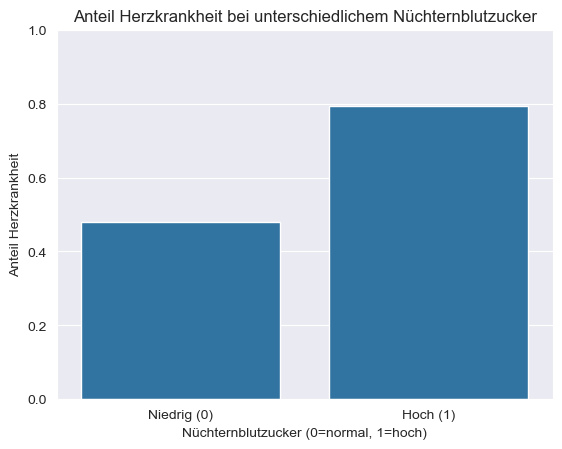

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


In [125]:
heart_disease_rate = df.groupby("FastingBS")["HeartDisease"].mean().reset_index()

sns.barplot(data=heart_disease_rate, x="FastingBS", y="HeartDisease")

plt.xticks([0, 1], ['Niedrig (0)', 'Hoch (1)'])
plt.ylabel("Anteil Herzkrankheit")
plt.xlabel("Nüchternblutzucker (0=normal, 1=hoch)")
plt.title("Anteil Herzkrankheit bei unterschiedlichem Nüchternblutzucker")
plt.ylim(0, 1)
plt.show()

print(df.groupby("FastingBS")["HeartDisease"].mean())

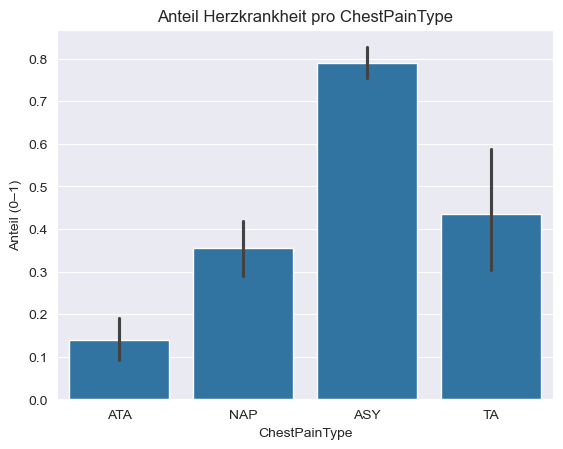

Anteil an Herzkrankheiten (%) pro ChestPainType:

ChestPainType
ASY    79.03
TA     43.48
NAP    35.47
ATA    13.87
Name: HeartDisease, dtype: float64


In [126]:
sns.barplot(
    data=df,
    x='ChestPainType',
    y='HeartDisease',
    estimator=lambda x: sum(x) / len(x)  # Mittelwert = Anteil Herzkrankheit
)
plt.title("Anteil Herzkrankheit pro ChestPainType")
plt.ylabel("Anteil (0–1)")
plt.show()

heart_disease_by_cp = df.groupby("ChestPainType")["HeartDisease"].mean().sort_values(ascending=False) * 100

print("Anteil an Herzkrankheiten (%) pro ChestPainType:\n")
print(heart_disease_by_cp.round(2))

## Feature Engineering

In [127]:
# Resting BP
def restingBP_categorization(bp):
    if bp < 120:
        return 100
    elif 120<= bp <= 129:
        return 125
    elif 130<= bp <= 139:
        return 135
    elif 140<= bp <= 179:
        return 160
    else: return 190

df['RestingBP'] = df['RestingBP'].apply(restingBP_categorization)

def cholesterol_category_by_age(row):
    age = row['Age']
    sex = row['Sex']
    chol = row['Cholesterol']

    # Wertebereiche laut Tabelle (vereinfacht)
    if sex == 'M':  # Männer
        if age < 40:
            min_val, max_val = 150, 220
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 240
        else:
            min_val, max_val = 175, 240
    else:  # Frauen
        if age < 40:
            min_val, max_val = 150, 240
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 260
        else:
            min_val, max_val = 195, 270

    if chol < min_val:
        return 0
    elif chol > max_val:
        return 1
    else:
        return 0.5

df['Cholesterol_cat_age'] = df.apply(cholesterol_category_by_age, axis=1)

# Max HR
def maxhr_age_category(row):
    maxhr = row['MaxHR']
    age = row['Age']
    expected_maxhr = 220 - age

    if maxhr < 0.7 * expected_maxhr:
        return 1
    elif 0.7 * expected_maxhr <= maxhr <= expected_maxhr:
        return 2
    elif expected_maxhr < maxhr <= 1.1 * expected_maxhr:
        return 3
    else:
        return 4

df['MaxHR'] = df.apply(maxhr_age_category, axis=1)


def age_category(age_group):
    if age_group == '20–30':
        return 25
    elif age_group == '31–40':
        return 36
    elif age_group == '41–50':
        return 46
    elif age_group == '51–60':
        return 56
    elif age_group == '61–80':
        return 70
    else:
        return 0

df['Age_cat'] = df['Age_cat'].apply(age_category)

#One Hot Encoding bei Nominalen Kategorien
df = pd.get_dummies(df, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True, dtype=int)

# Mapping für Sex (Männlich = 1, Weiblich = 0)
df["Sex"] = df["Sex"].map({'M': 1, 'F': 0})

# Mapping für ExerciseAngina (Ja = 1, Nein = 0)
df["ExerciseAngina"] = df["ExerciseAngina"].map({'Y': 1, 'N': 0})

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df


In [128]:
#Skalieren
scaler = MinMaxScaler()
scale_cols = ["RestingBP", "Cholesterol", "MaxHR", "ExerciseAngina", "Oldpeak", "Age_cat"]

df[scale_cols] = scaler.fit_transform(df[scale_cols])

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

# Machine Learning

In [129]:
X = df.drop(columns=['HeartDisease', 'Age', 'Cholesterol'])
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Random Forrest

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8691


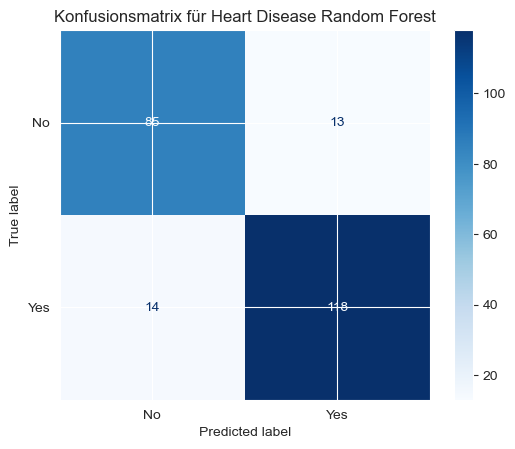

Genauigkeit: 0.8826086956521739

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.820513   0.636364  0.700000  0.666667        0.282051
1    0.895288   0.925000  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.346


In [130]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Fairness-Analyse nach Geschlecht

sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


### RF mit Balanced

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8735


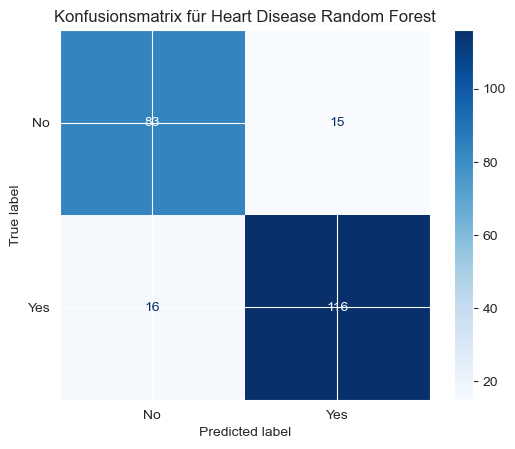

Genauigkeit: 0.8652173913043478


In [131]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}


rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)


print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)


### Fairnes Analyse

In [132]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")



Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872   0.583333  0.700000  0.636364        0.307692
1    0.879581   0.915966  0.893443  0.904564        0.623037
Demographic Parity Difference: 0.315


### Top 10 RF Merkmale

ST_Slope_Up: 0.0400 ± 0.0139
ST_Slope_Flat: 0.0322 ± 0.0156
Cholesterol_cat_age: 0.0304 ± 0.0058
Oldpeak: 0.0191 ± 0.0103
FastingBS: 0.0183 ± 0.0051
Sex: 0.0126 ± 0.0066
ExerciseAngina: 0.0070 ± 0.0087
ChestPainType_ATA: 0.0061 ± 0.0062
Age_cat: 0.0057 ± 0.0052
RestingBP: 0.0057 ± 0.0073


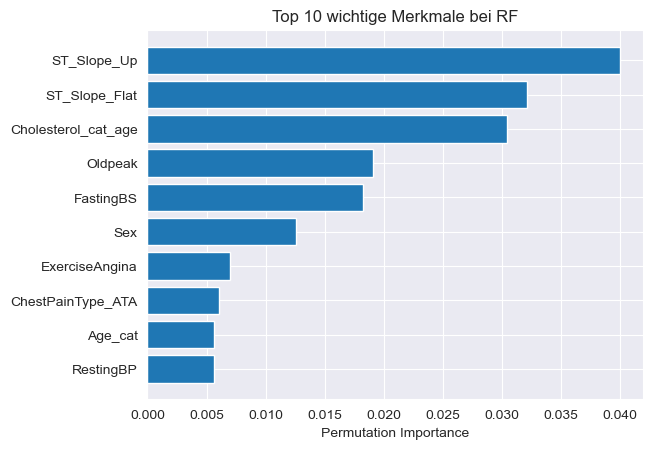

In [133]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

### Analyse mit SHAP

In [134]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test, check_additivity=False)

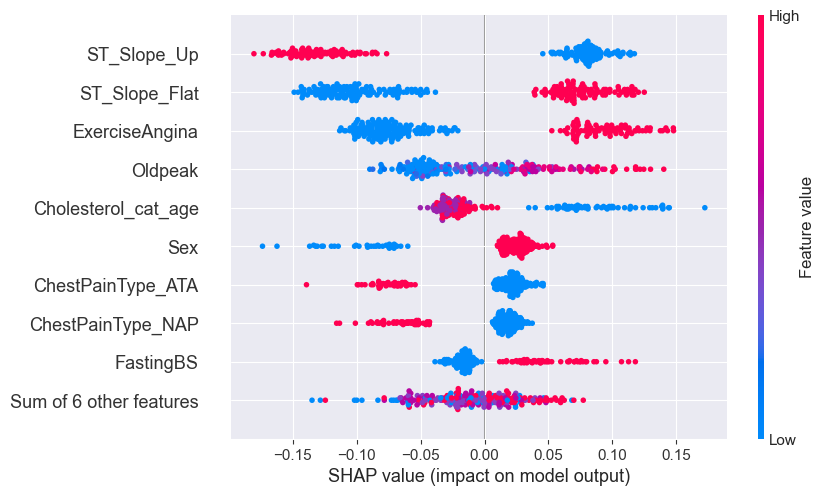

In [135]:
shap.plots.beeswarm(shap_values[:, :, 1])

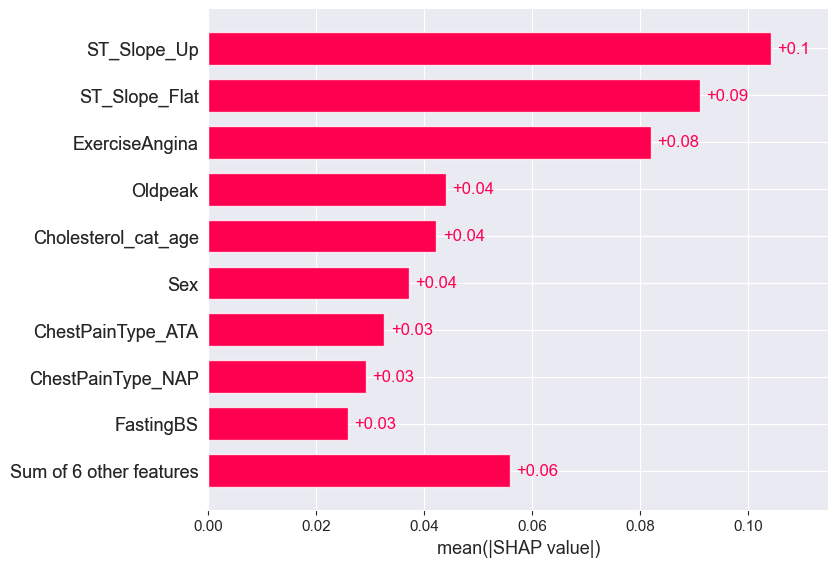

In [136]:
#Bar-Plot der wichtigsten Merkmale
shap.plots.bar(shap_values[:, :, 1])

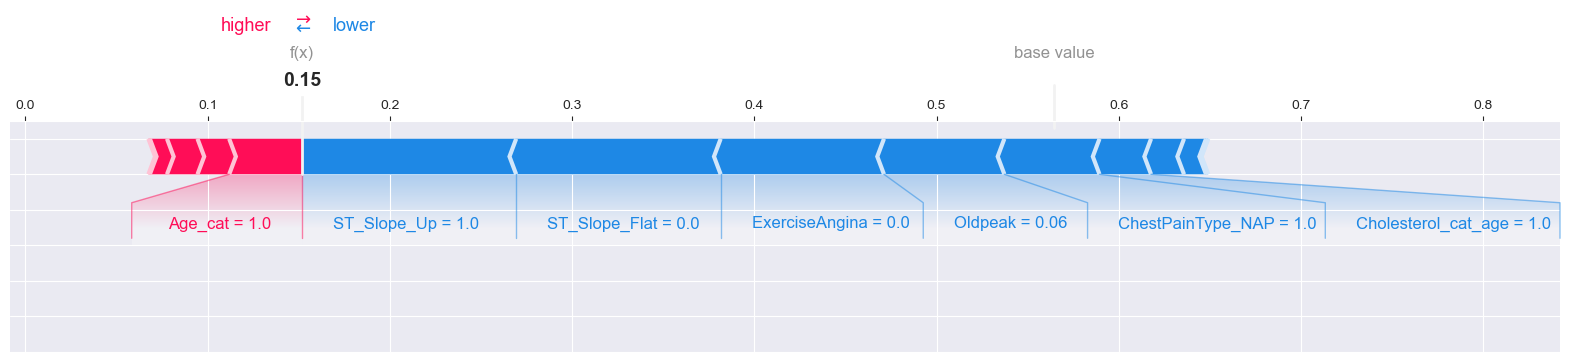

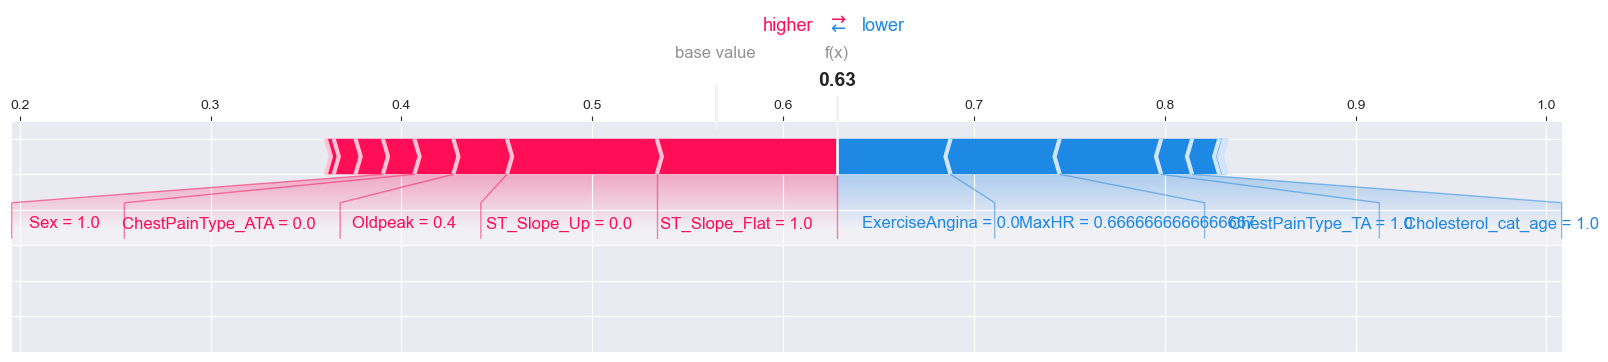

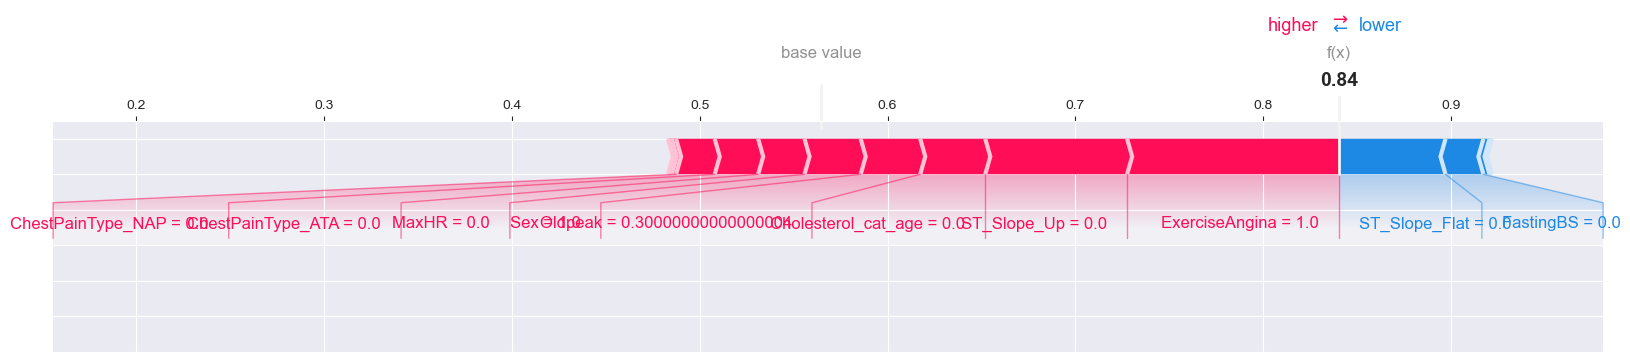

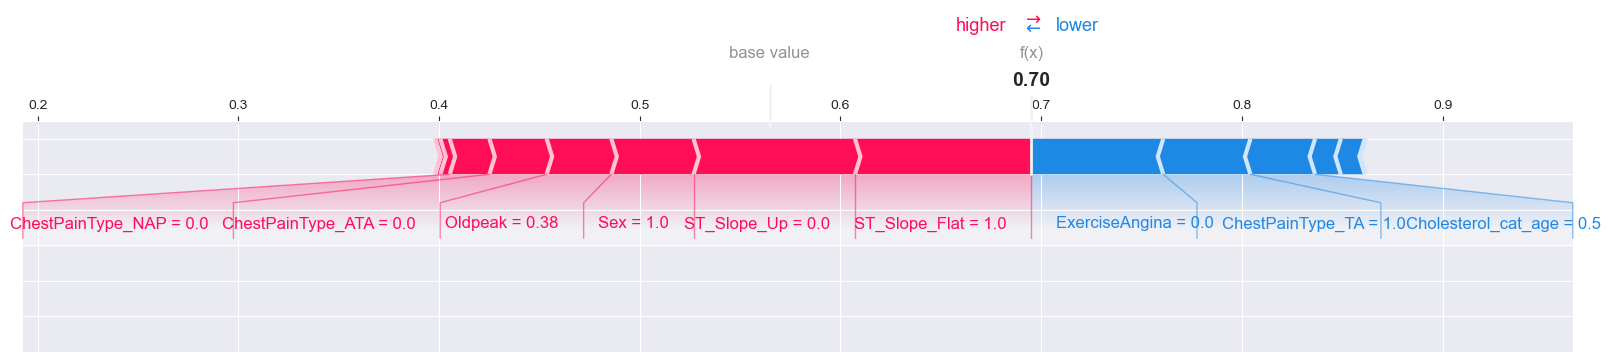

In [137]:
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values[index, :, 1], matplotlib=True)

## Logistic Regression Balanced

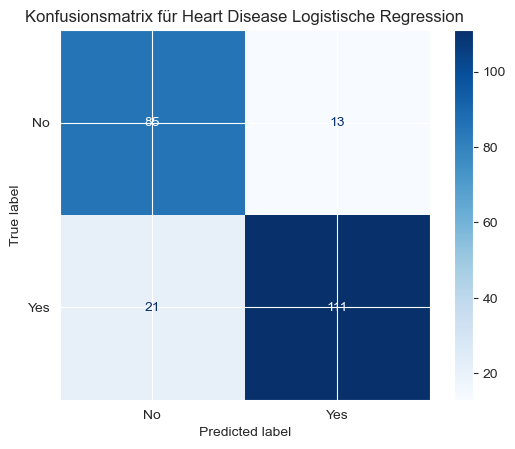

Genauigkeit: 0.8521739130434782
Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.743590   0.500000  0.500000  0.500000        0.256410
1    0.874346   0.929825  0.868852  0.898305        0.596859
Demographic Parity Difference: 0.340


In [138]:
#logisticRegeression balanced
modelLogistic = LogisticRegression(max_iter=1000,class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

#Fariness:

# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


### Top 10 LR Merkmale

FastingBS: 0.0261 ± 0.0085
ChestPainType_ATA: 0.0209 ± 0.0134
ChestPainType_NAP: 0.0170 ± 0.0100
Cholesterol_cat_age: 0.0130 ± 0.0089
ST_Slope_Flat: 0.0096 ± 0.0097
Sex: 0.0091 ± 0.0081
ST_Slope_Up: 0.0065 ± 0.0115
ChestPainType_TA: 0.0057 ± 0.0058
ExerciseAngina: 0.0039 ± 0.0121
Oldpeak: 0.0004 ± 0.0057


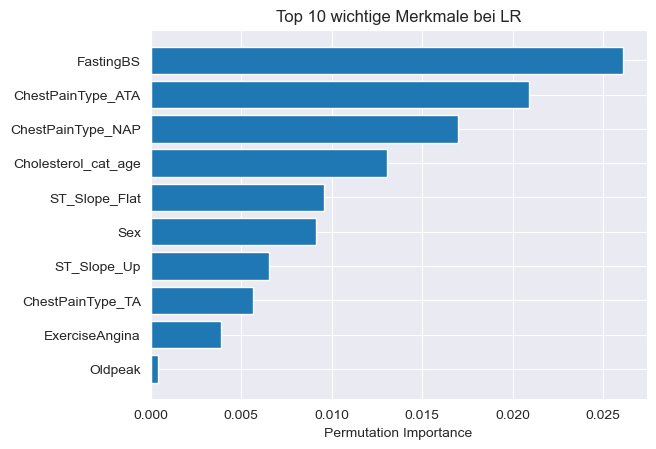

In [139]:
result = permutation_importance(modelLogistic, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

### SHAP Analyse

In [140]:
explainer = shap.Explainer(modelLogistic, X_train)
shap_values_lr = explainer(X_test)

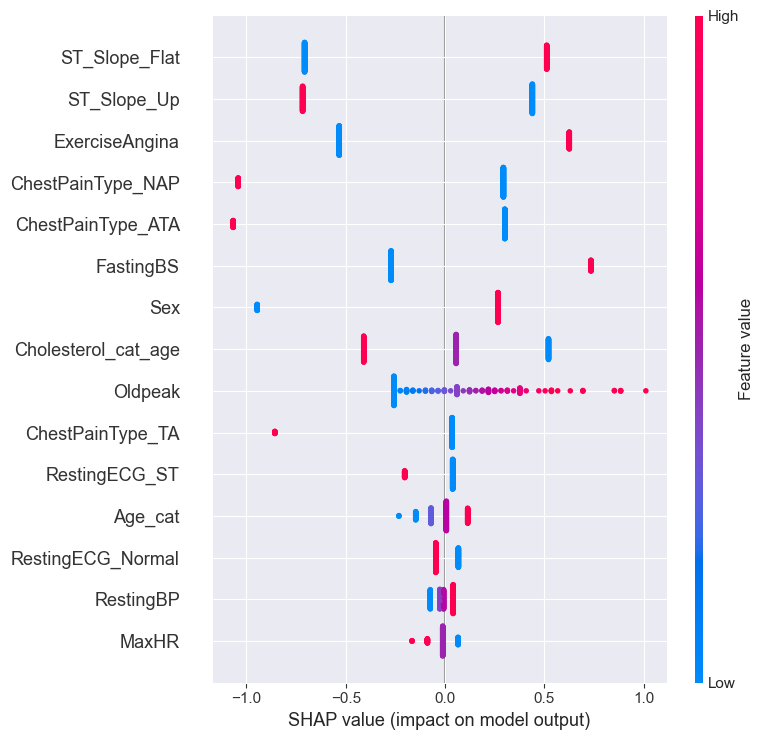

In [141]:
shap.summary_plot(shap_values_lr, X_test)

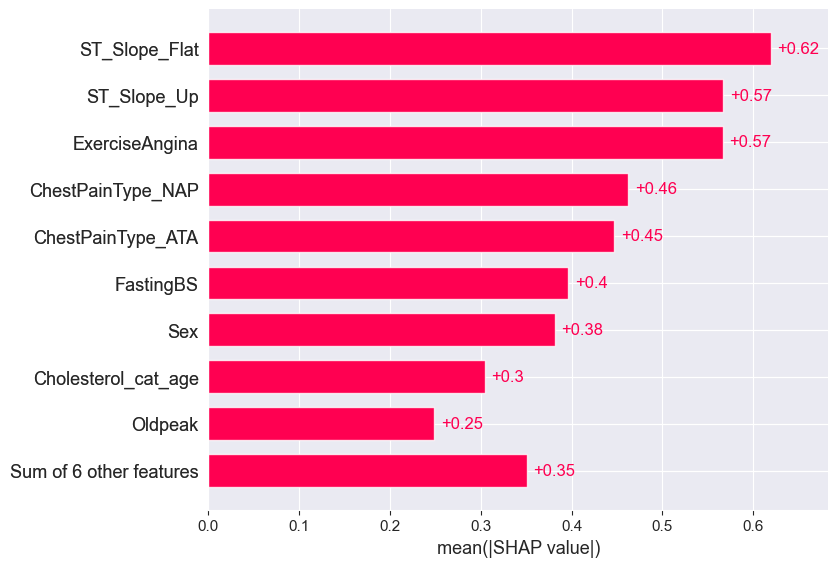

In [142]:
shap.plots.bar(shap_values_lr)

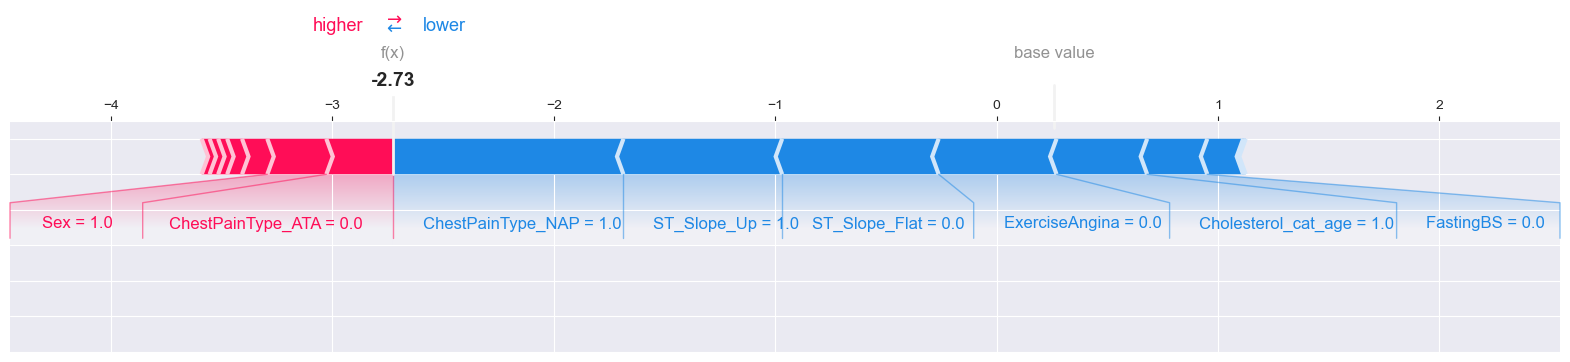

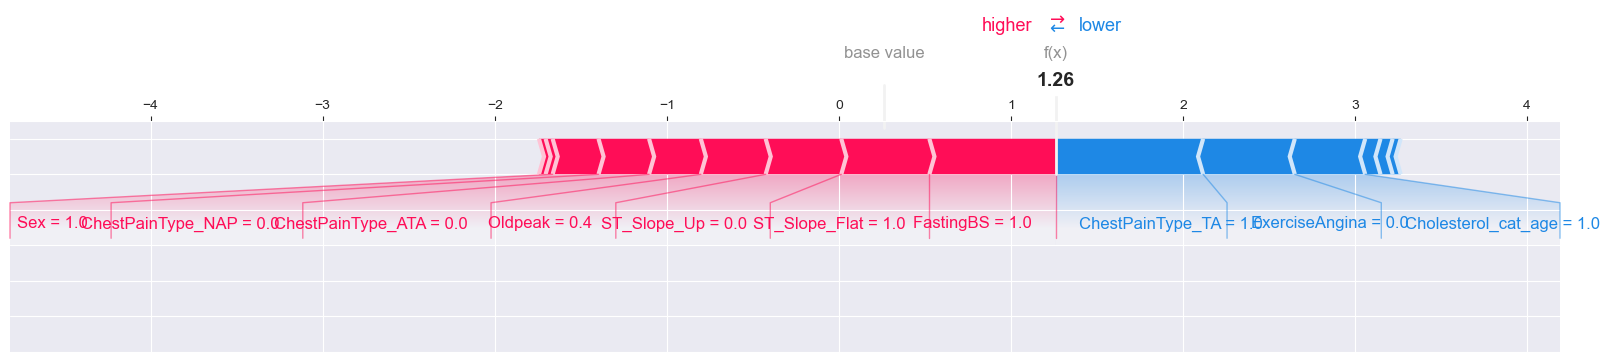

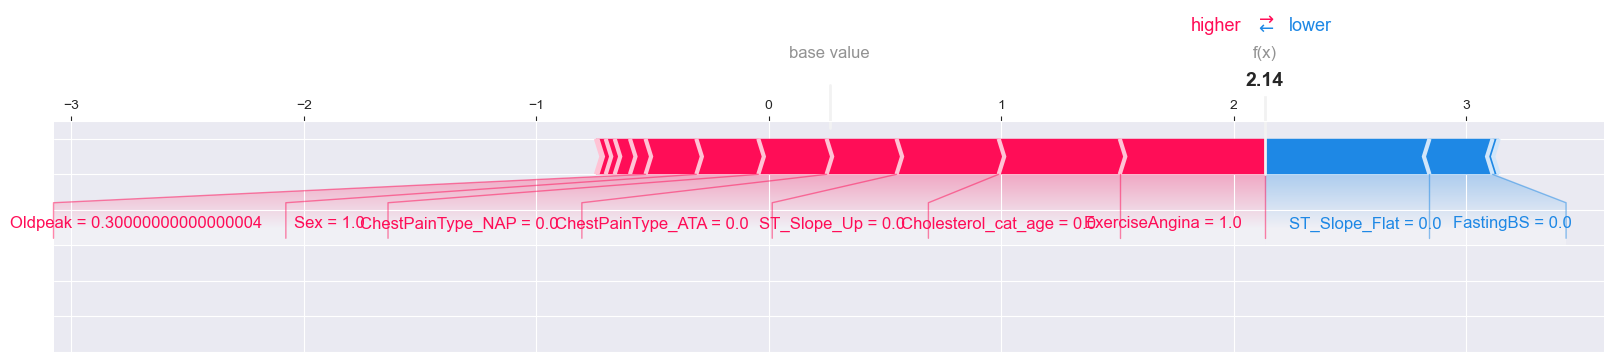

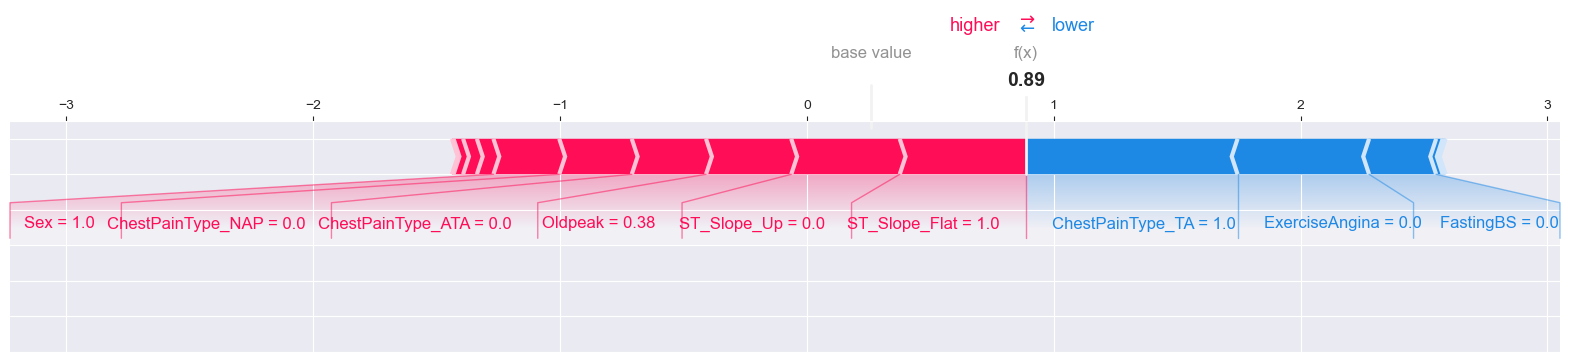

In [143]:
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values_lr[index], matplotlib=True)

## Frauen Oversampled

In [144]:
# 3. Oversampling von Frauen im Trainingsteil
train_df = X_train.copy()
train_df["HeartDisease"] = y_train

# Get Frauen (Sex == 0) und Männer
women = train_df[train_df["Sex"] == 0]
men = train_df[train_df["Sex"] == 1]

# Frauen duplizieren, bis gleiche Anzahl wie Männer
women_oversampled = women.sample(n=len(men), replace=True, random_state=42)

# Kombinieren
train_f_oversampled = pd.concat([men, women_oversampled])
X_train_f_oversampled = train_f_oversampled.drop(columns="HeartDisease")
y_train_f_oversampled = train_f_oversampled["HeartDisease"]

### Random Forrest

Neue Verteilung im Training:
Sex
1    534
0    534
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9074


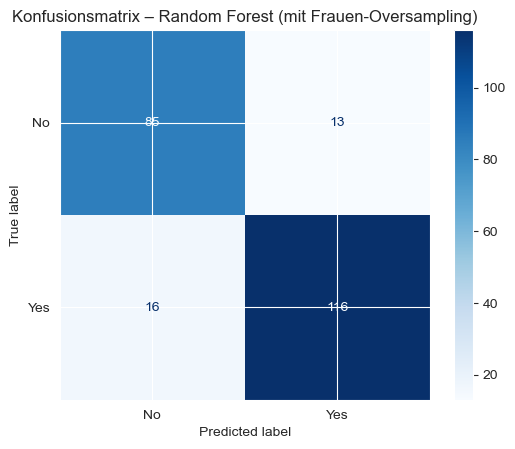

Genauigkeit: 0.8739130434782608

 Predictive Parity (Female): 0.636
 Predictive Parity (Male):   0.924
 Predictive Parity Difference: 0.287

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate  \
Sex                                                            
0    0.820513   0.636364  0.700000  0.666667        0.282051   
1    0.884817   0.923729  0.893443  0.908333        0.617801   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.137931            0.700000  
1               0.130435            0.893443  
Demographic Parity Difference: 0.336


In [145]:
print(f"Neue Verteilung im Training:\n{X_train_f_oversampled['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_f_oversampled, y_train_f_oversampled)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Top 10 Random Forrest Merkmale

ST_Slope_Up: 0.0352 ± 0.0169
Cholesterol_cat_age: 0.0343 ± 0.0060
ST_Slope_Flat: 0.0317 ± 0.0179
Oldpeak: 0.0304 ± 0.0097
ChestPainType_ATA: 0.0296 ± 0.0072
FastingBS: 0.0270 ± 0.0058
Sex: 0.0239 ± 0.0065
ChestPainType_NAP: 0.0183 ± 0.0087
ExerciseAngina: 0.0148 ± 0.0101
ChestPainType_TA: 0.0100 ± 0.0028


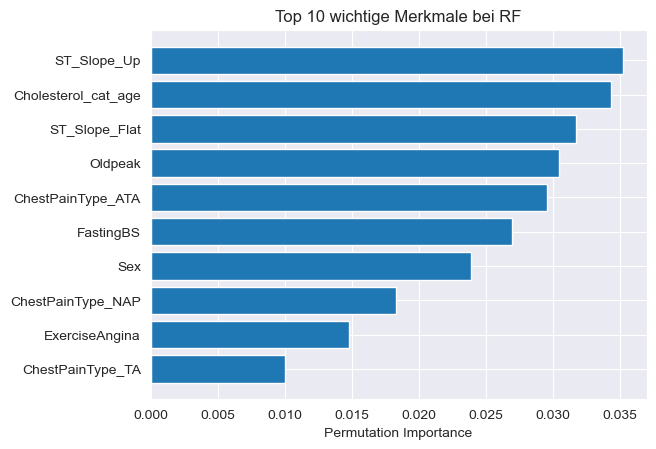

In [146]:
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

### SHAP Analyse

In [147]:

shap.initjs()
explainer = shap.Explainer(best_forest_model, X_train_f_oversampled)
shap_values = explainer(X_test, check_additivity=False)

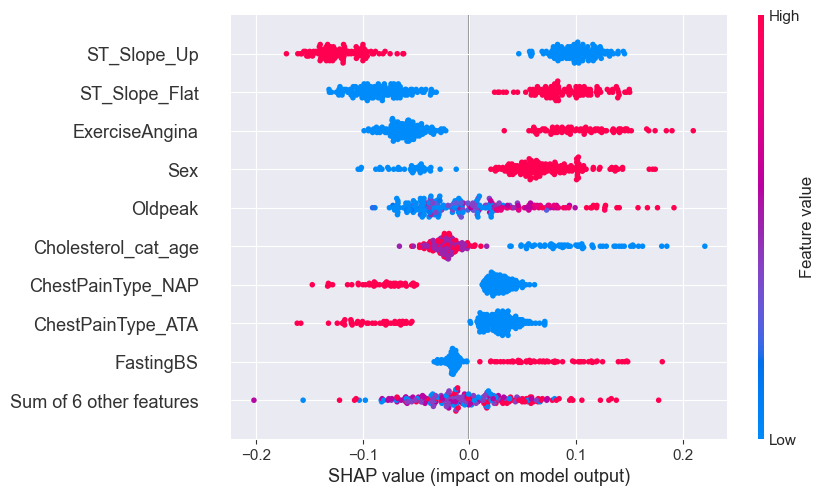

In [148]:
shap.plots.beeswarm(shap_values[:, :, 1])

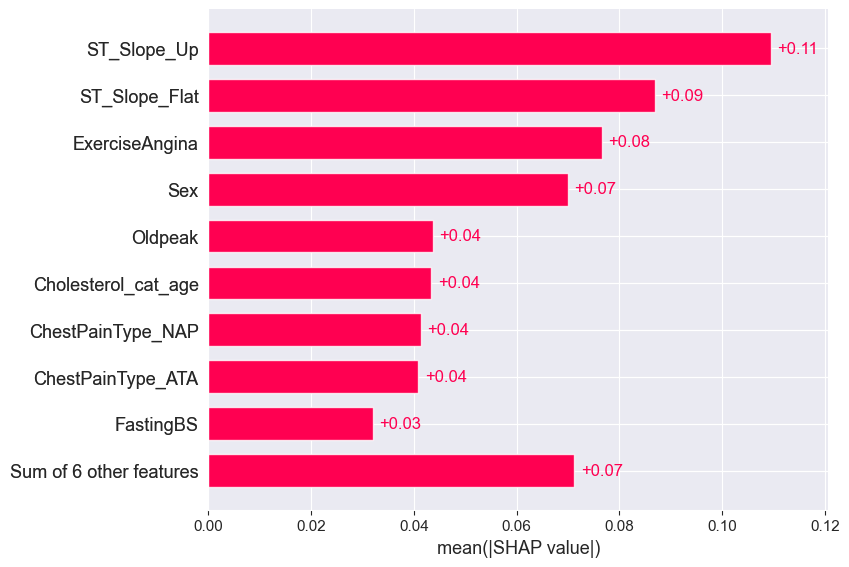

In [149]:
shap.plots.bar(shap_values[:, :, 1])

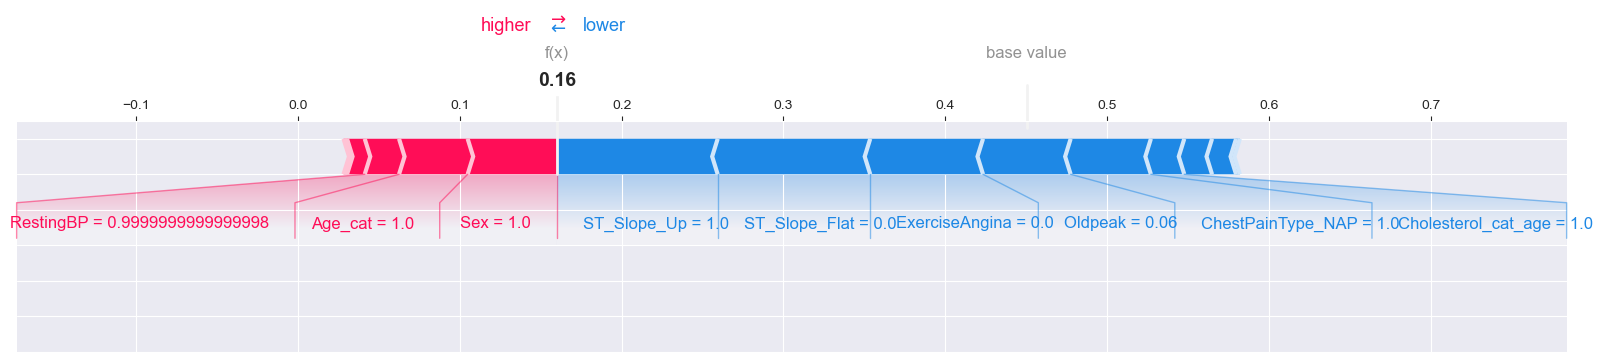

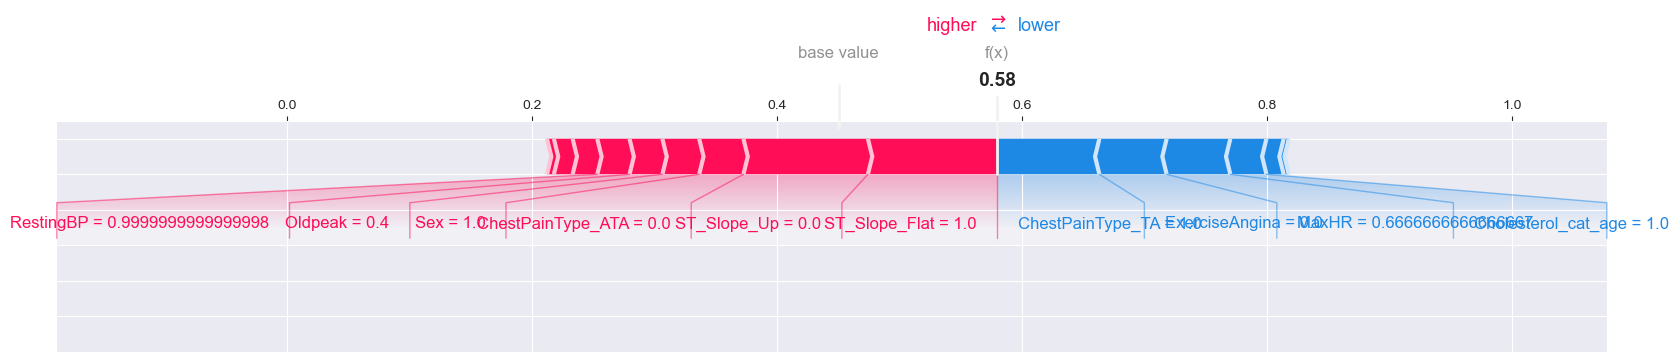

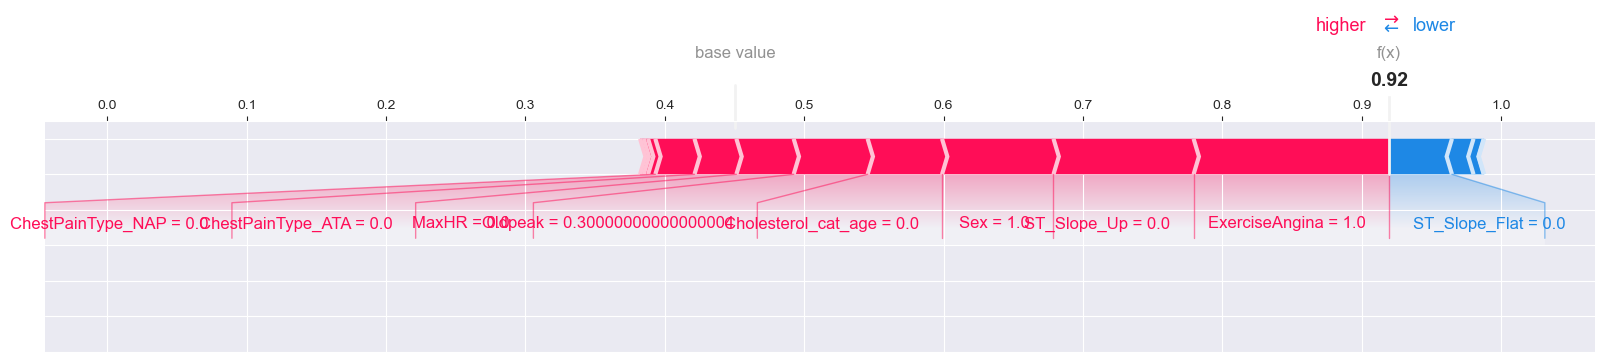

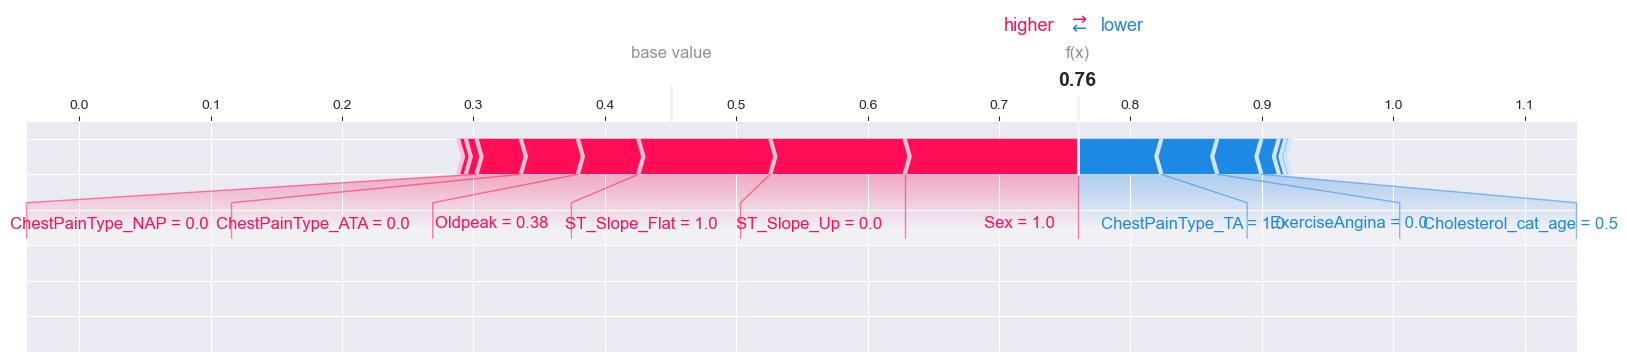

In [150]:
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values[index, :, 1], matplotlib=True)

## Smote

In [151]:
from imblearn.over_sampling import SMOTE

# SMOTE anwenden nur auf Trainingsdaten
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_f_oversampled, y_train_f_oversampled)

# 4. Ausgabe zur Kontrolle
print("Vor SMOTE:", y_train.value_counts())
print("Nach SMOTE:", y_train_resampled.value_counts())

Vor SMOTE: HeartDisease
1    376
0    312
Name: count, dtype: int64
Nach SMOTE: HeartDisease
1    606
0    606
Name: count, dtype: int64


### Random Forest mit Smote

In [152]:
print(f"Neue Verteilung im Training:\n{X_train_resampled['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

Neue Verteilung im Training:
Sex
1    638
0    574
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9242


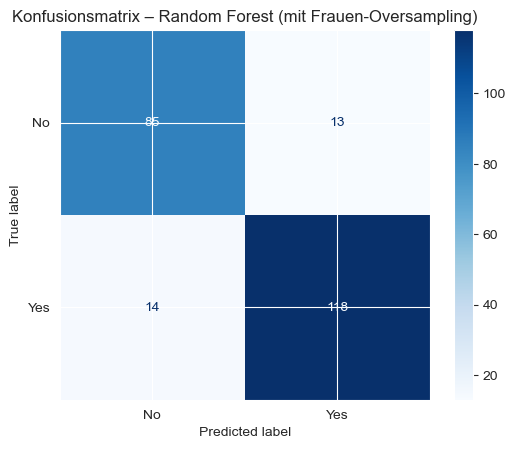

Accuracy: 0.8826086956521739
Precision: 0.9007633587786259
Recall: 0.8939393939393939
F1-Score: 0.8973384030418251


In [153]:
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rand)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rand)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_rand)
print("F1-Score:", f1)


In [154]:

# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")


 Predictive Parity (Female): 0.636
 Predictive Parity (Male):   0.925
 Predictive Parity Difference: 0.289


#### Fairnes Analyse

In [155]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate  \
Sex                                                            
0    0.820513   0.636364  0.700000  0.666667        0.282051   
1    0.895288   0.925000  0.909836  0.917355        0.628272   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.137931            0.700000  
1               0.130435            0.909836  
Demographic Parity Difference: 0.346


#### TOP 10

ST_Slope_Up: 0.0409 ± 0.0103
Cholesterol_cat_age: 0.0383 ± 0.0087
FastingBS: 0.0313 ± 0.0067
ChestPainType_ATA: 0.0278 ± 0.0081
ST_Slope_Flat: 0.0261 ± 0.0159
Oldpeak: 0.0243 ± 0.0107
Sex: 0.0222 ± 0.0096
ChestPainType_NAP: 0.0196 ± 0.0073
RestingBP: 0.0178 ± 0.0074
MaxHR: 0.0117 ± 0.0062


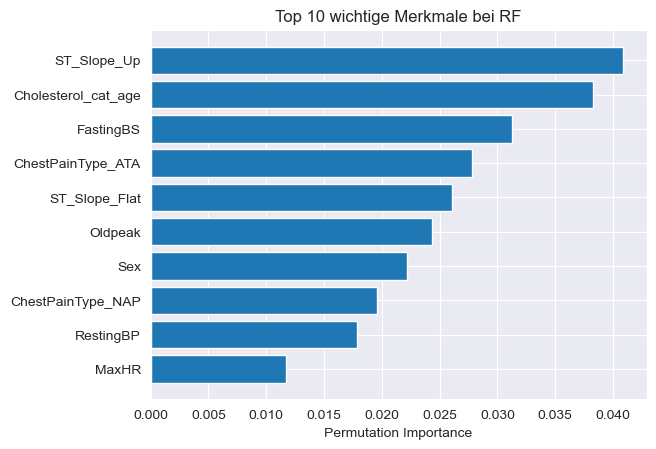

In [156]:
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")


plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()


#### SHAP

In [157]:
shap.initjs()
explainer_rf = shap.Explainer(best_forest_model, X_train_resampled)
shap_values_rf = explainer_rf(X_test)

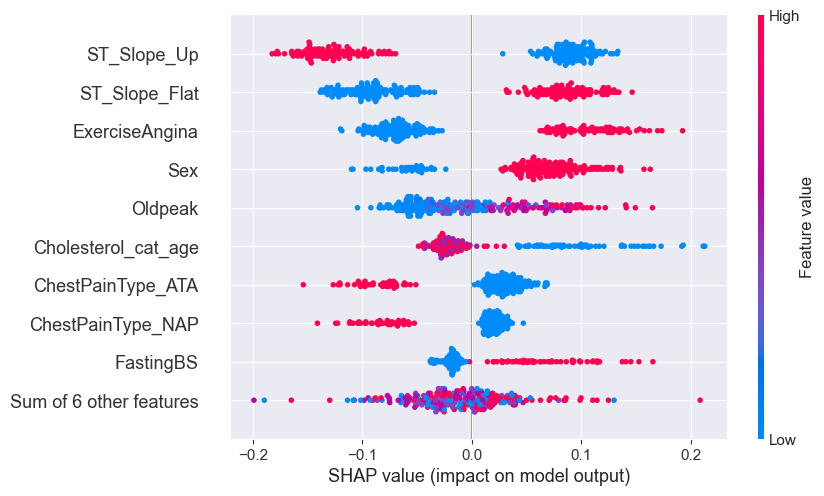

In [158]:
shap.plots.beeswarm(shap_values_rf[:, :, 1])

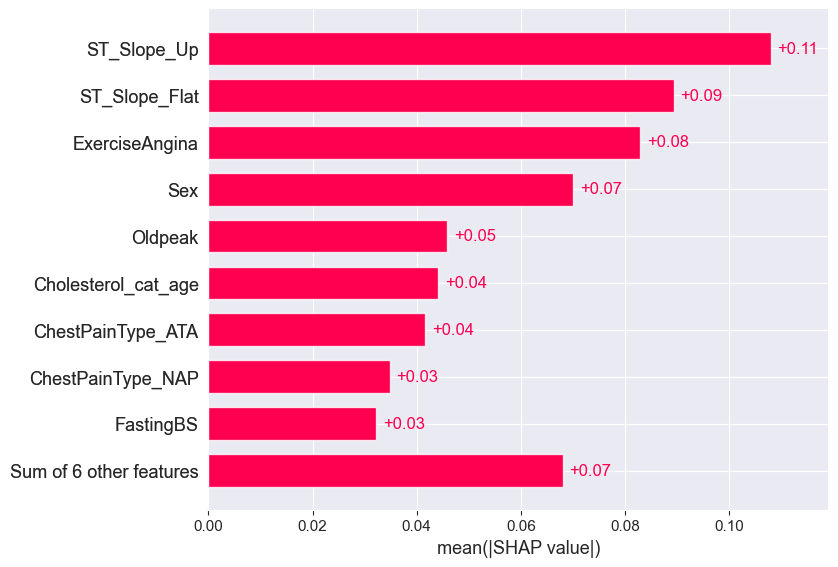

In [159]:
shap.plots.bar(shap_values_rf[:, :, 1])

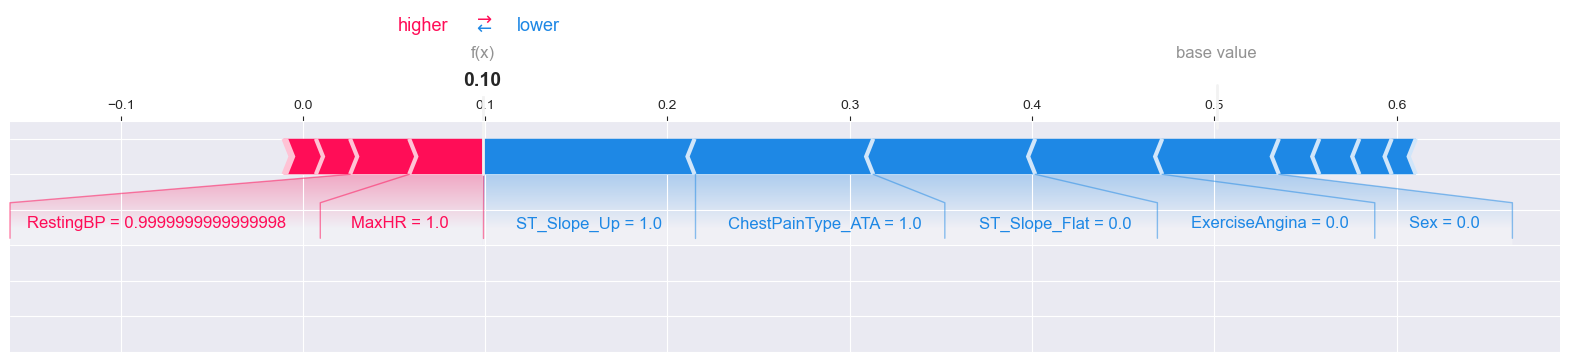

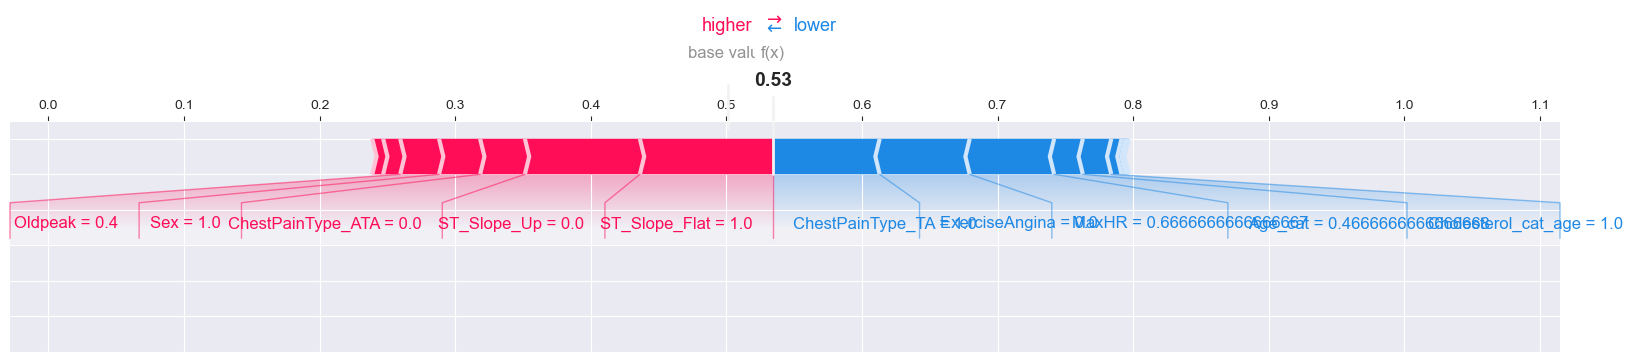

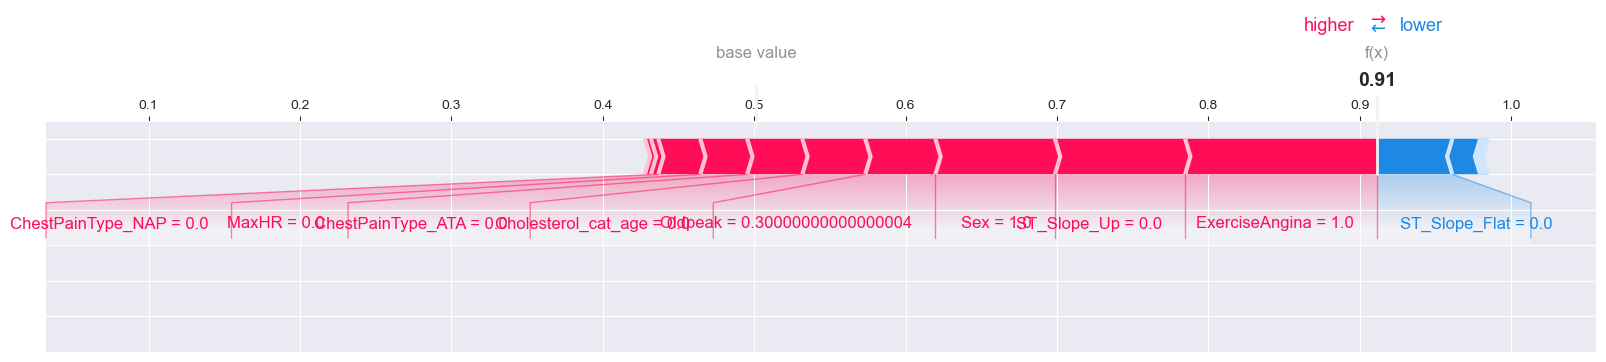

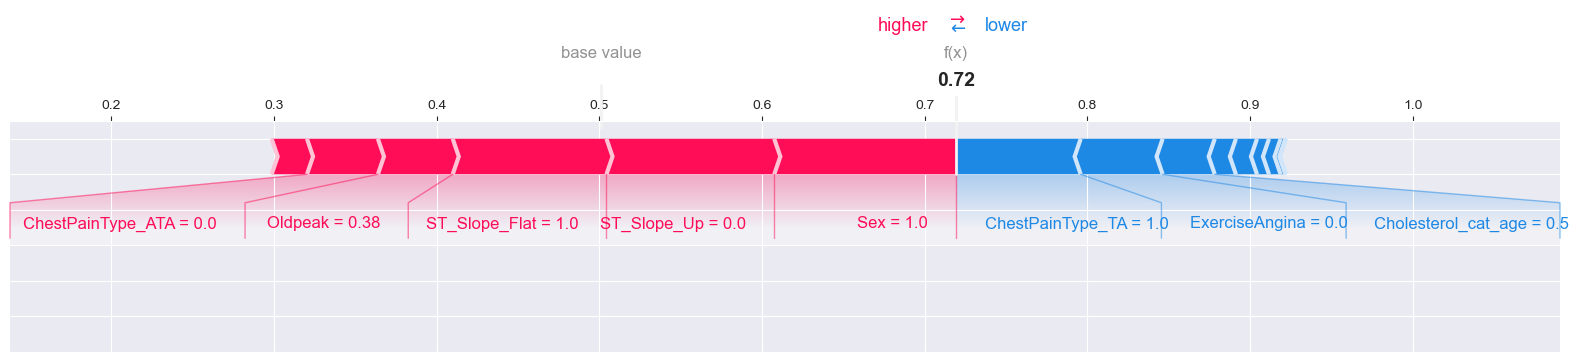

In [160]:
indices = [0, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values_rf[index, :, 1], matplotlib=True)

### Logistic Regression mit Smote

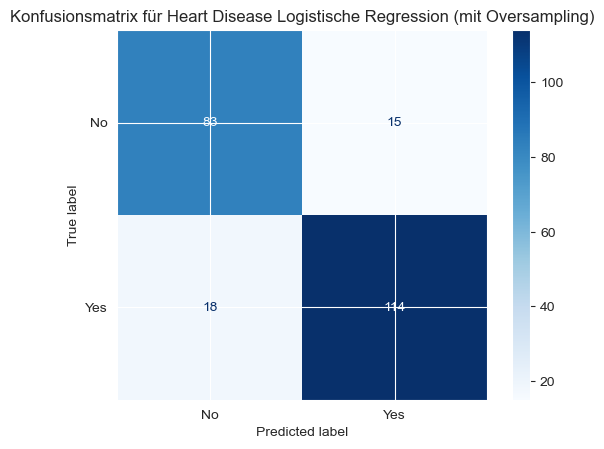

Genauigkeit: 0.8565217391304348
Precision: 0.8837209302325582
Recall: 0.8636363636363636
F1-Score: 0.8735632183908046


In [161]:
best_lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
best_lr_model.fit(X_train_resampled, y_train_resampled)

y_pred_log = best_lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression (mit Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_log)
print("Genauigkeit:", accuracy)
precision = precision_score(y_test, y_pred_log)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_log)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_log)
print("F1-Score:", f1)

#### Fairness Analyse nach Sex

In [162]:
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_log, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_log, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")



Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.545455  0.600000  0.571429        0.282051
1    0.874346   0.915254  0.885246  0.900000        0.617801
Demographic Parity Difference: 0.336


#### Top 10

ChestPainType_NAP: 0.0339 ± 0.0143
ChestPainType_ATA: 0.0248 ± 0.0162
ExerciseAngina: 0.0161 ± 0.0091
FastingBS: 0.0157 ± 0.0096
Sex: 0.0143 ± 0.0108
ST_Slope_Up: 0.0109 ± 0.0115
ST_Slope_Flat: 0.0104 ± 0.0110
Oldpeak: 0.0061 ± 0.0029
ChestPainType_TA: 0.0052 ± 0.0095
Age_cat: 0.0022 ± 0.0035


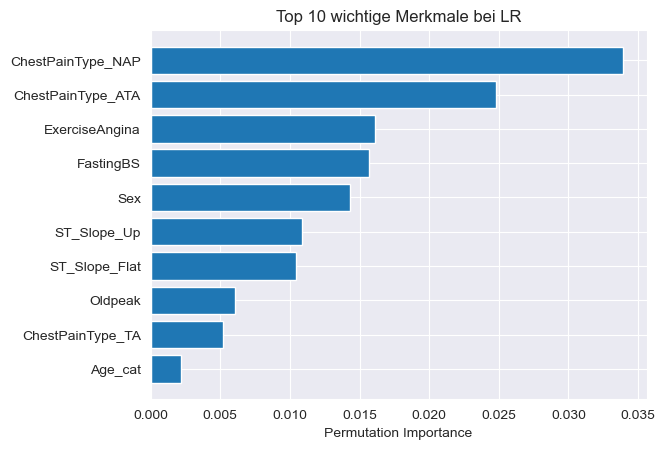

In [163]:
#Top 10 wichtigste Merkmale bei LR
result = permutation_importance(best_lr_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

#### SHAP

In [164]:
explainer_lr = shap.Explainer(modelLogistic, X_train)
shap_values_lr = explainer_lr(X_test)

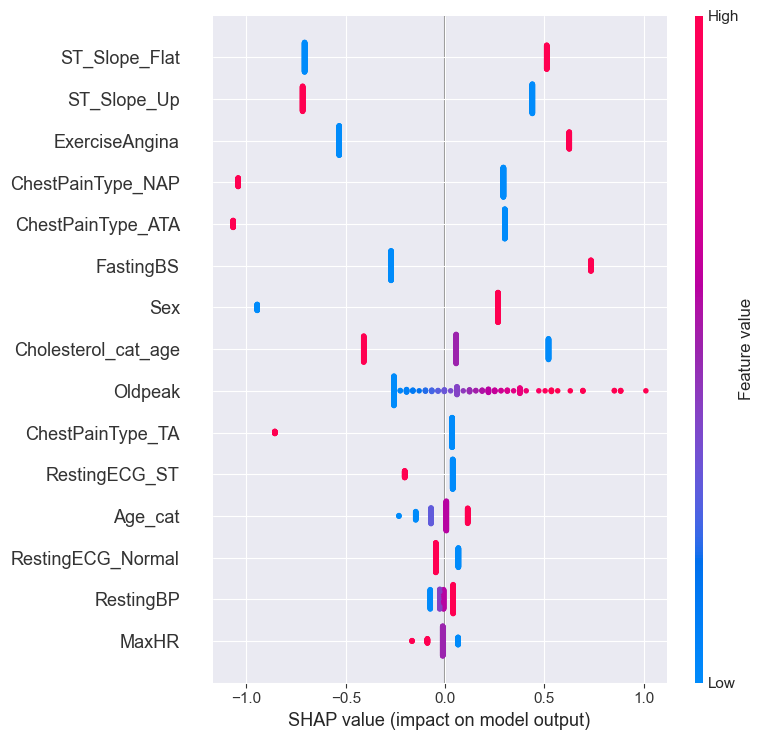

In [165]:
shap.summary_plot(shap_values_lr, X_test)

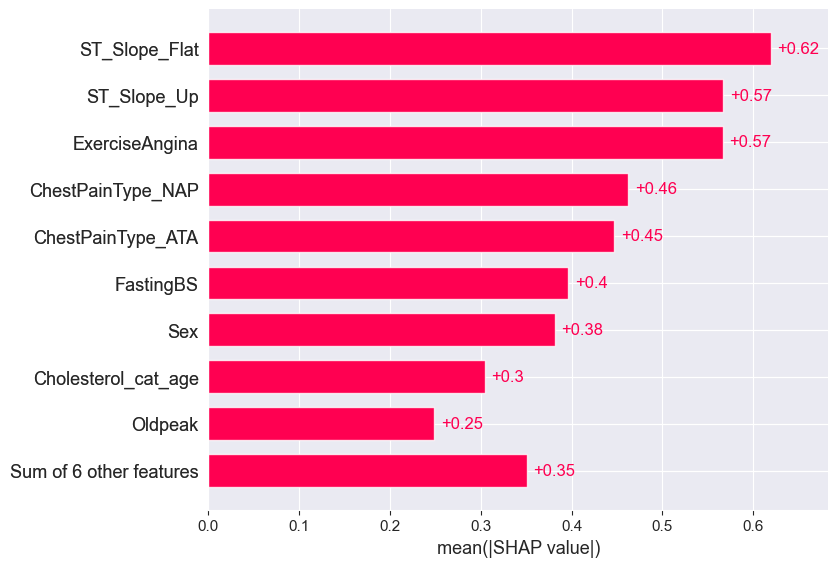

In [166]:

# Bar-Plot der durchschnittlichen Wichtigkeit
shap.plots.bar(shap_values_lr)

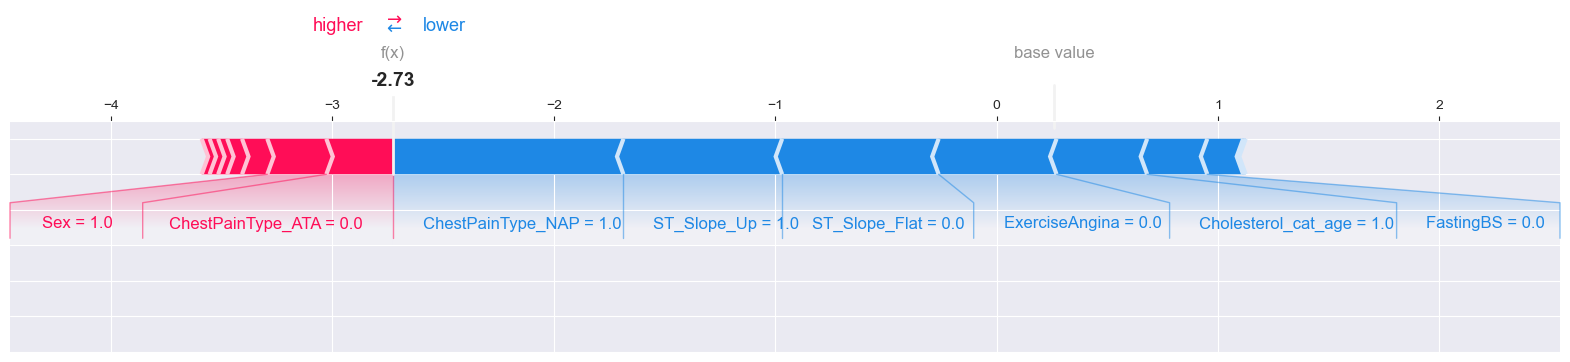

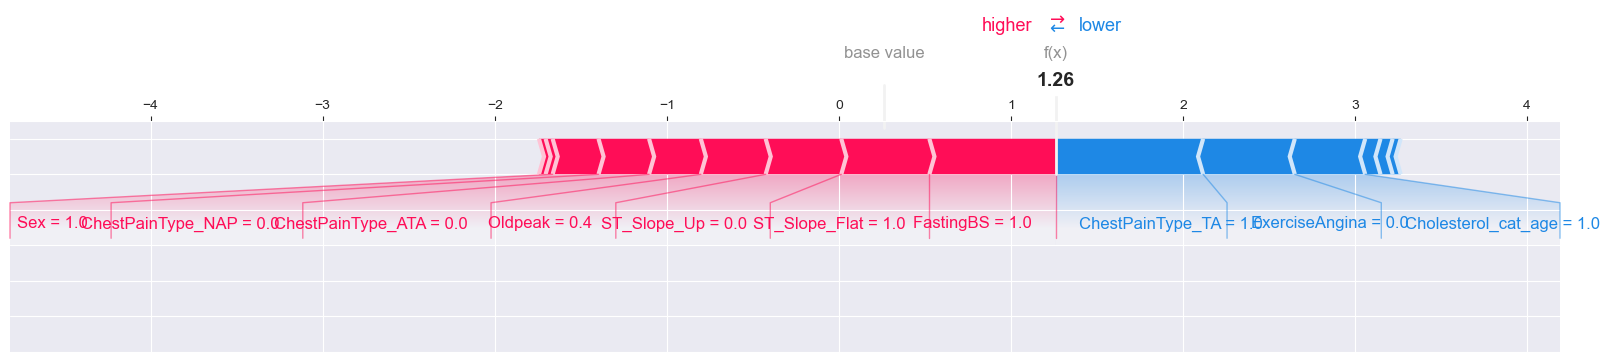

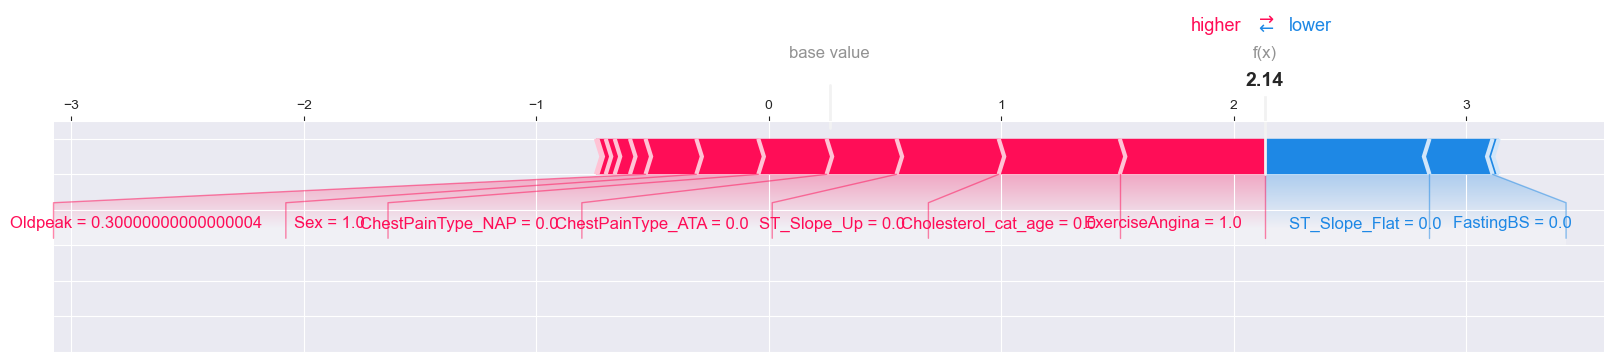

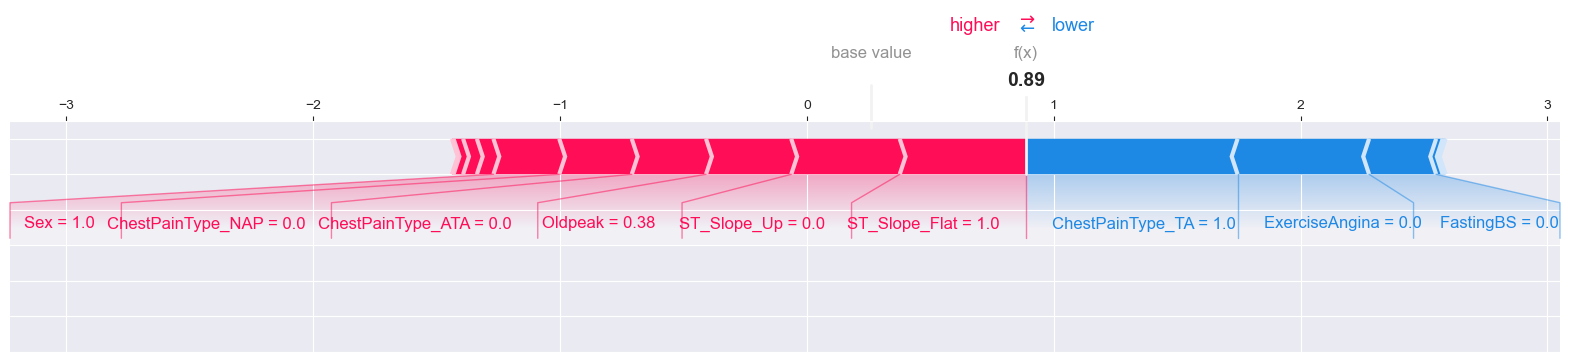

In [167]:

# Einzelne Datenpunkte analysieren
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values_lr[index], matplotlib=True)

## Stacking LR, RF

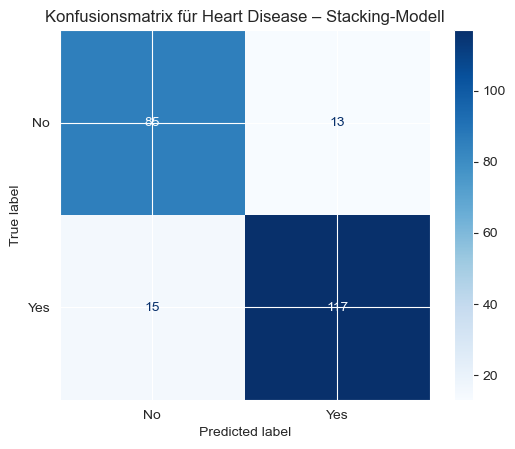

Genauigkeit (Stacking): 0.8782608695652174

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872      0.600  0.600000  0.600000        0.256410
1    0.895288      0.925  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.372


In [168]:
# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_resampled, y_train_resampled)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

## XG Boost

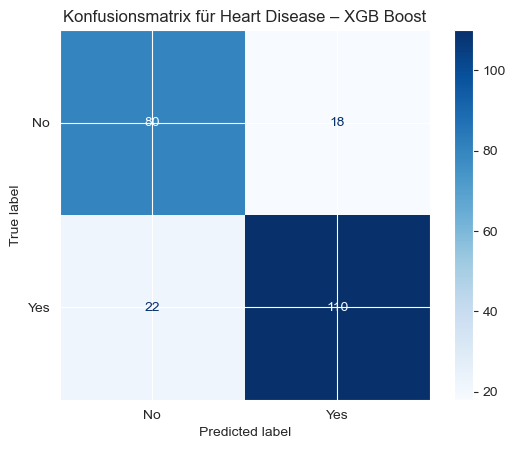

Accuracy: 0.8260869565217391
Precision: 0.859375
Recall: 0.8333333333333334
F1-Score: 0.8461538461538461


In [169]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – XGB Boost')
plt.show()

accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_xgb)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_xgb)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_xgb)
print("F1-Score:", f1)

### Fairness Analyse nach Geschlecht

In [170]:

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (XGB Boost):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex' (XGB Boost):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872      0.600  0.600000  0.600000        0.256410
1    0.895288      0.925  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.372


### SHAP Analyse

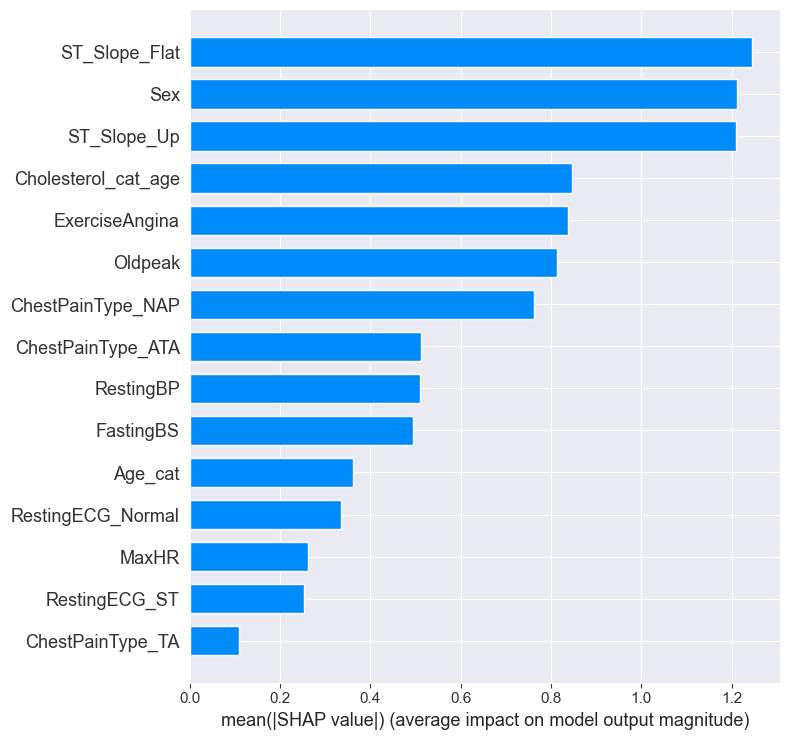

In [171]:
explainer_xgb = shap.Explainer(xgb_model, X_train_resampled)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

## Stacking LR, RF und XG Boost

### Stacking

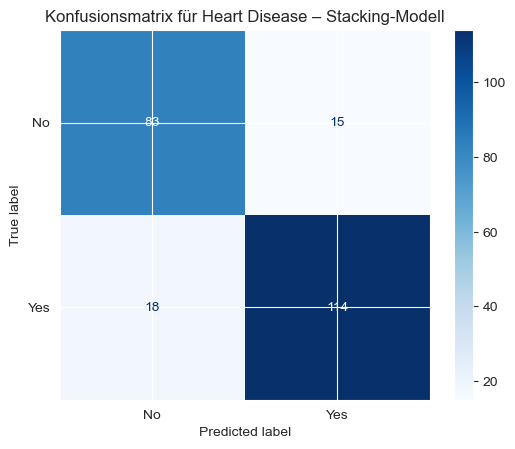

Genauigkeit: 0.8565217391304348
Precision: 0.8837209302325582
Recall: 0.8636363636363636
F1-Score: 0.8735632183908046


In [183]:

estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_resampled, y_train_resampled)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit:", accuracy)
precision = precision_score(y_test, y_pred_stack)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_stack)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_stack)
print("F1-Score:", f1)

### Fairnes Analyse

In [173]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.545455  0.600000  0.571429        0.282051
1    0.874346   0.915254  0.885246  0.900000        0.617801
Demographic Parity Difference: 0.336


### Impact der einzelnen Modelle

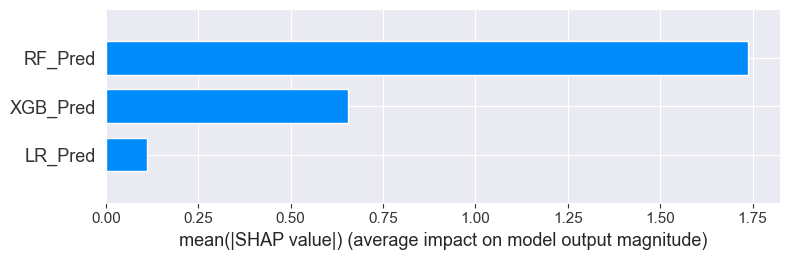

In [174]:

rf_pred = best_forest_model.predict_proba(X_test)[:, 1]
lr_pred = best_lr_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

meta_features = np.column_stack((rf_pred, lr_pred, xgb_pred))

explainer = shap.Explainer(stacked_model.final_estimator_, meta_features)

shap_values = explainer(meta_features)

feature_names = ["RF_Pred", "LR_Pred", "XGB_Pred"]

shap.summary_plot(shap_values, features=meta_features, feature_names=feature_names, plot_type="bar")


## Voting

### Hart Voting

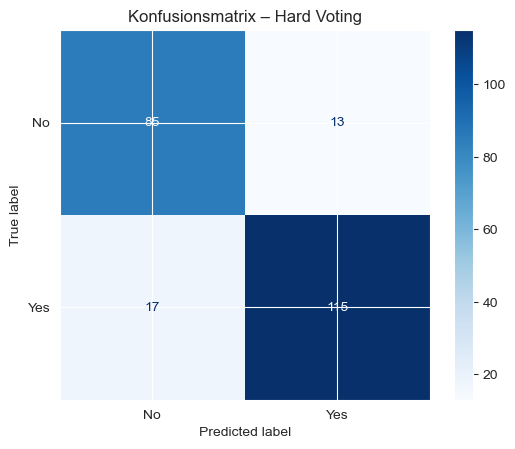

Genauigkeit: 0.8695652173913043
Precision: 0.8984375
Recall: 0.8712121212121212
F1-Score: 0.8846153846153846


In [175]:
from sklearn.ensemble import VotingClassifier

voting_model_hard = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', best_lr_model),
        ('xgb', xgb_model)
    ],
    voting='hard',
    n_jobs=-1
)

voting_model_hard.fit(X_train_resampled, y_train_resampled)

y_pred_hard = voting_model_hard.predict(X_test)

cm_hard = confusion_matrix(y_test, y_pred_hard)
disp_hard = ConfusionMatrixDisplay(confusion_matrix=cm_hard, display_labels=['No', 'Yes'])
disp_hard.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Hard Voting")
plt.show()

accuracy = accuracy_score(y_test, y_pred_hard)
print("Genauigkeit:", accuracy)
precision = precision_score(y_test, y_pred_hard)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_hard)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_hard)
print("F1-Score:", f1)

### Soft Voting

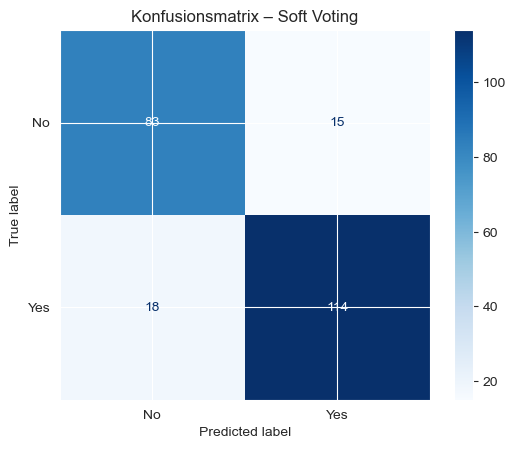

Genauigkeit: 0.8565217391304348
Precision: 0.8837209302325582
Recall: 0.8636363636363636
F1-Score: 0.8735632183908046


In [184]:

voting_model_soft = VotingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('lr', best_lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_model_soft.fit(X_train_resampled, y_train_resampled)

y_pred_soft = voting_model_soft.predict(X_test)

# Wahrscheinlichkeiten für AUC
y_proba_soft = voting_model_soft.predict_proba(X_test)[:, 1]

cm_soft = confusion_matrix(y_test, y_pred_soft)
disp_soft = ConfusionMatrixDisplay(confusion_matrix=cm_soft, display_labels=['No', 'Yes'])
disp_soft.plot(cmap='Blues')
plt.title("Konfusionsmatrix – Soft Voting")
plt.show()

accuracy = accuracy_score(y_test, y_pred_soft)
print("Genauigkeit:", accuracy)
precision = precision_score(y_test, y_pred_soft)
print("Precision:", precision)
recall = recall_score(y_test, y_pred_soft)
print("Recall:", recall)
f1 = f1_score(y_test, y_pred_soft)
print("F1-Score:", f1)

### Vergleich Hart und Soft

In [177]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate(name, y_true, y_predi, y_prob=None):
    print(f"  {name}")
    print(f"  Accuracy:  {accuracy_score(y_true, y_predi):.4f}")
    print(f"  Precision: {precision_score(y_true, y_predi):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_predi):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_predi):.4f}")
    if y_prob is not None:
        print(f"  AUC:       {roc_auc_score(y_true, y_prob):.4f}")
    print()

evaluate("Hard Voting", y_test, y_pred_hard)
evaluate("Soft Voting", y_test, y_pred_soft, y_proba_soft)


  Hard Voting
  Accuracy:  0.8696
  Precision: 0.8984
  Recall:    0.8712
  F1 Score:  0.8846

  Soft Voting
  Accuracy:  0.8565
  Precision: 0.8837
  Recall:    0.8636
  F1 Score:  0.8736
  AUC:       0.9341



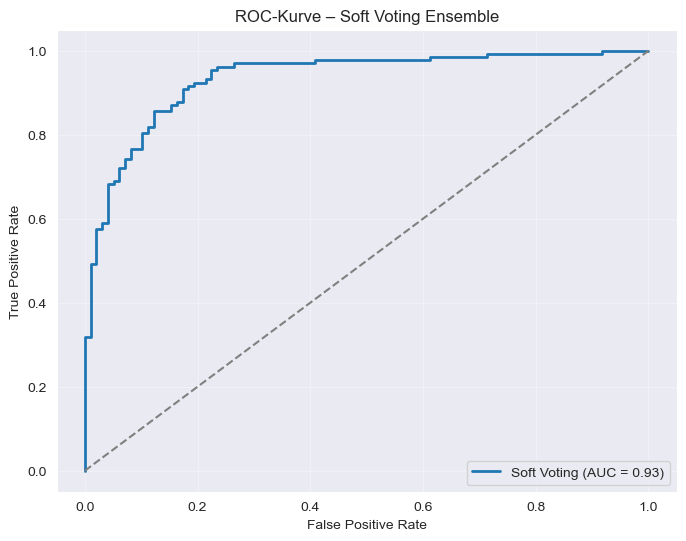

In [178]:

y_proba = voting_model_soft.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Soft Voting (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Zufallslinie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve – Soft Voting Ensemble')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Vergleich Merkmale über die 3 Modelle

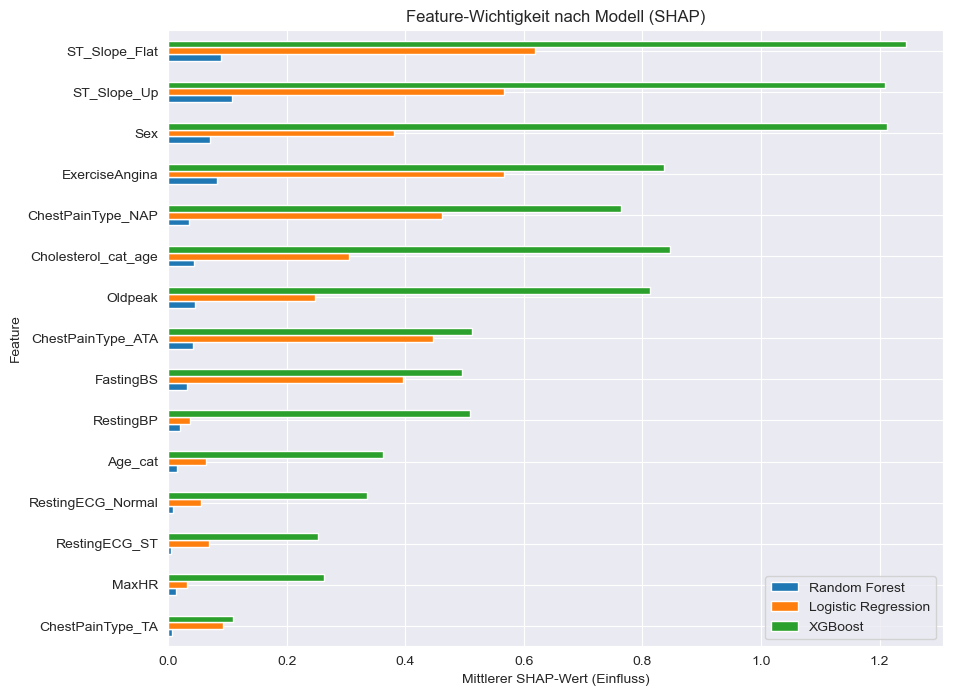

In [179]:

mean_rf = np.abs(shap_values_rf.values[:, :, 1]).mean(axis=0)
mean_lr = np.abs(shap_values_lr.values).mean(axis=0)
mean_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Random Forest": mean_rf,
    "Logistic Regression": mean_lr,
    "XGBoost": mean_xgb
}).set_index("Feature")


shap_df["Mean"] = shap_df.mean(axis=1)
shap_df = shap_df.sort_values("Mean")

shap_df.drop(columns="Mean").plot(kind="barh", figsize=(10, 8), title="Feature-Wichtigkeit nach Modell (SHAP)")
plt.xlabel("Mittlerer SHAP-Wert (Einfluss)")
plt.show()


# Erklärbarkeit auf eine Person

Index der ausgewählten Person: 96
Vorhersagen für eine Testperson:
Random Forest:           Krankheit
Logistische Regression:  Krankheit
XGBoost:                 Krankheit
Voting:                  Krankheit
Wahrer Wert:             Krankheit


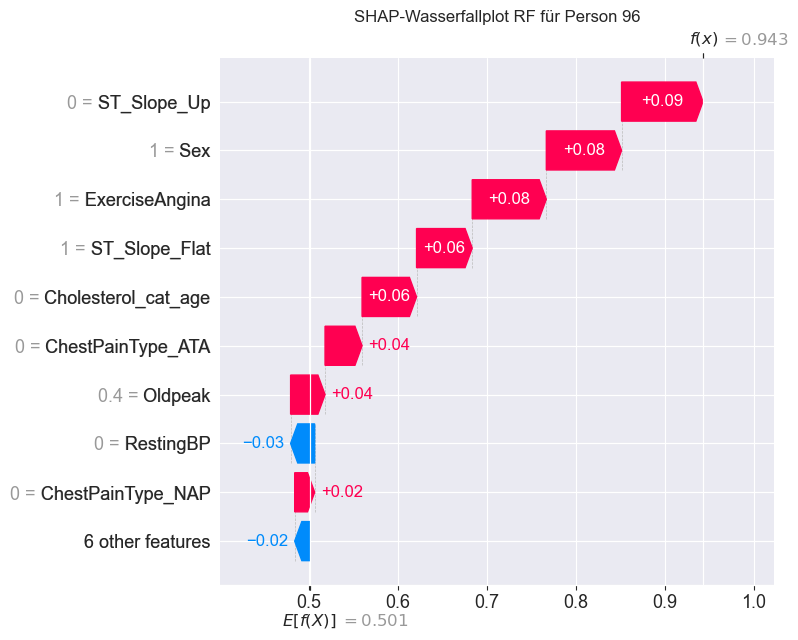

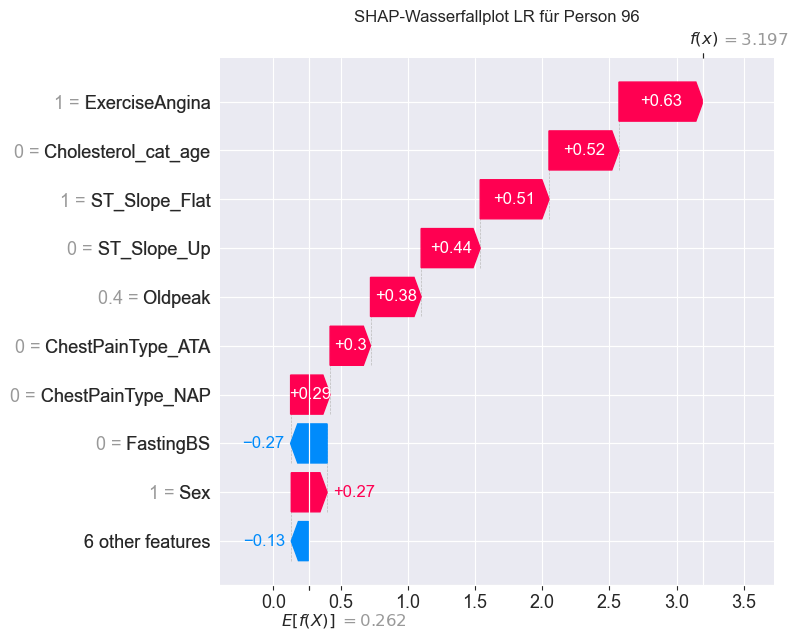

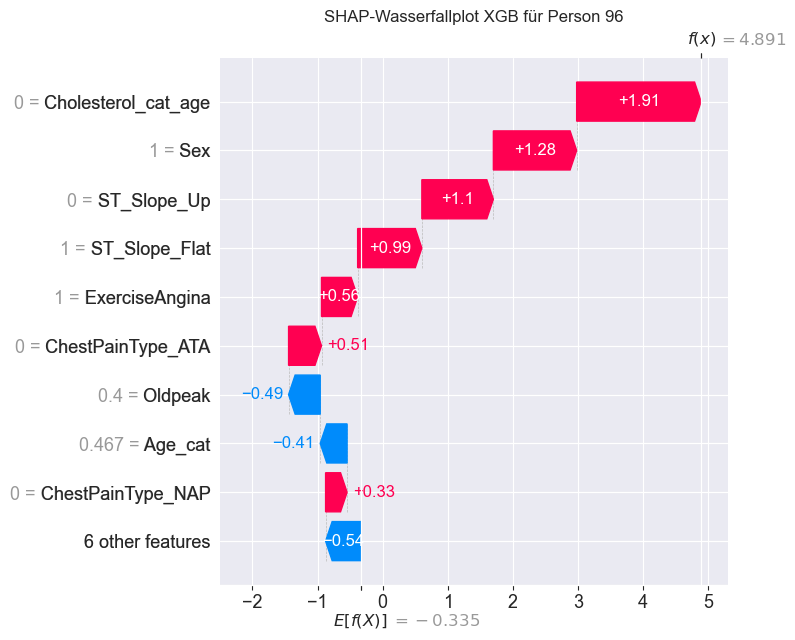

In [180]:
import random

idx = random.randint(0, X_test.shape[0] - 1)
#idx = 70
print(f"Index der ausgewählten Person: {idx}")
person = X_test.iloc[[idx]]  # als DataFrame

pred_rf = best_forest_model.predict(person)[0]
pred_lr = best_lr_model.predict(person)[0]
pred_xgb = xgb_model.predict(person)[0]
pred_voting = voting_model_soft.predict(person)

print("Vorhersagen für eine Testperson:")
print(f"Random Forest:           {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")
print(f"Logistische Regression:  {'Krankheit' if pred_lr == 1 else 'Keine Krankheit'}")
print(f"XGBoost:                 {'Krankheit' if pred_xgb == 1 else 'Keine Krankheit'}")
print(f"Voting:                  {'Krankheit' if pred_voting == 1 else 'Keine Krankheit'}")

true_label = y_test.iloc[idx]
print(f"Wahrer Wert:             {'Krankheit' if pred_rf == 1 else 'Keine Krankheit'}")

shap_val_rf = explainer_rf(person)
shap_val_lr = explainer_lr(person)
shap_val_xgb = explainer_xgb(person)

fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_rf[0, :, 1], max_display=10, show=False)  # wichtig: show=False
plt.title(f"SHAP-Wasserfallplot RF für Person {idx}")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_lr[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot LR für Person {idx}")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
shap.plots.waterfall(shap_val_xgb[0], max_display=10, show=False)
plt.title(f"SHAP-Wasserfallplot XGB für Person {idx}")
plt.tight_layout()
plt.show()


In [181]:
voting_estimators = voting_model_soft.named_estimators_
models = ['Logistische Regression', 'Random Forest', 'XGBoost']

votes = [
    voting_estimators['lr'].predict(person)[0],
    voting_estimators['rf'].predict(person)[0],
    voting_estimators['xgb'].predict(person)[0]
]
probs = [
    voting_estimators['lr'].predict_proba(person)[0][1],
    voting_estimators['rf'].predict_proba(person)[0][1],
    voting_estimators['xgb'].predict_proba(person)[0][1]
]

table_data = []
for i in range(len(models)):
    vote_label = 'Krankheit' if votes[i] == 1 else 'Keine Krankheit'
    table_data.append([models[i], vote_label, f"{probs[i]:.2f}"])

mean_prob = np.mean(probs)
final_soft_vote = 1 if mean_prob >= 0.5 else 0
final_soft_vote_str = 'Krankheit' if final_soft_vote == 1 else 'Keine Krankheit'

table_data.append(["Soft Voting", final_soft_vote_str, f"{mean_prob:.2f}"])

fig, ax = plt.subplots(figsize=(8, 2.8))
ax.axis('off')

table = ax.table(
    cellText=table_data,
    colLabels=["Modell", "Vorhersage", "Wahrscheinlichkeit (Krankheit)"],
    loc='center',
    cellLoc='center',
    colColours=['lightgray'] * 3
)
